In [4]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils.behavioral_analysis import calculate_median_position
from utils.data_loading_and_preprocessing import get_dlc_df, preprocess_dlc_data
from utils.session_analysis import analyze_single_session, load_session_data, perform_correlation_analyses, perform_decoding_analyses, analyze_all_sessions
from utils.visualization import plot_correlation_histogram, plot_cross_context_correlation, plot_decoding_comparison, plot_raster_pos_neg, plot_context_preference, plot_mean_speed_comparison, plot_roi, visualize_annotated_frame, plot_rotary_wheel_alignment, plot_unsorted_raster, plot_raster_pos_neg
import matplotlib.pyplot as plt
from utils.statistical_testing import run_permutation_test, categorise_neurons
import pandas as pd
from types import SimpleNamespace as Bunch
import seaborn as sns
from scipy.stats import binned_statistic_2d
from IPython.display import display
import numpy as np
import pandas as pd
import os
import glob
from scipy.io import loadmat
from pinkrigs_tools.dataset.query import load_data
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import math
import cv2

In [6]:
results = analyze_all_sessions(my_sessions, correlation=True, decoding=True, leaveout=False)

AV043
2024-03-04
No probe1 data found
AV043
2024-03-05
No probe1 data found
AV043
2024-03-12
No probe0 data found
No probe1 data found
error:{e}
No spike counts were provided
No spike counts were provided
AV043
2024-03-13
No probe1 data found
AV043
2024-03-14
No probe1 data found
AV043
2024-03-26
No probe0 data found
No probe1 data found
error:{e}
No spike counts were provided
No spike counts were provided
EB036
2024-03-19
EB036
2024-03-20
EB036
2024-03-22
EB037
2024-03-20
EB037
2024-03-21
EB037
2024-03-22
GB011
2024-05-09
GB011
2024-05-14
GB011
2024-05-15
GB011
2024-05-16
GB011
2024-05-17
GB012
2024-06-19
GB012
2024-06-20
GB012
2024-06-21
GB012
2024-06-25
GB012
2024-07-11
No probe0 data found
No probe1 data found
error:{e}
No spike counts were provided
No spike counts were provided
GB012
2024-07-16


In [7]:
run_permutation_test(results)

In [391]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

def plot_arena_correlation_distributions(all_session_results):
    """Plot wheel correlation distributions for each mouse/brain region."""
    
    # Define colors
    colors = {
        'hippocampus': "#A5CB5D",  
        'striatum': "#E37A2A",
        'MOs(1)': "#660D0D",  # AV043
        'MOs(2)': "#9F3A3A",  # GB011  
        'MOs(3)': "#D26E6E"   # GB012
    }
    
    # Organize data by subject
    data_by_subject = {}
    for result in all_session_results:
        if result.spike_counts is None:
            continue
        
        subject_id = result.metadata.subject_id
        if subject_id not in data_by_subject:
            data_by_subject[subject_id] = []
        
        # Get wheel correlations
        data_by_subject[subject_id].append(result.correlations.arena)
    
    # For MOs mice (AV043, GB011, GB012), randomly select 3 sessions
    mos_subjects = ['AV043', 'GB011', 'GB012']
    for subject in mos_subjects:
        if subject in data_by_subject:
            n_sessions = len(data_by_subject[subject])
            if n_sessions > 3:
                indices = random.sample(range(n_sessions), 3)
                data_by_subject[subject] = [
                    data_by_subject[subject][i] for i in indices
                ]
    
    # Create single figure with wider aspect ratio
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
    
    # Define order and labels for plotting
    plot_order = [
        ('AV043', 'MOs1', 'MOs(1)'),
        ('GB011', 'MOs2', 'MOs(2)'),
        ('GB012', 'MOs3', 'MOs(3)'),
        ('EB037', 'striatum', 'striatum'),
        ('EB036', 'hippocampus', 'hippocampus')
    ]
    
    positions = []
    labels = []
    spacing = 1.5  # Increased spacing between histograms
    
    for idx, (subject_id, label, color_key) in enumerate(plot_order):
        position = idx * spacing  # Apply spacing multiplier
        
        if subject_id in data_by_subject:
            positions.append(position)
            labels.append(label)
            
            # Pool all correlations from selected sessions
            pooled_correlations = []
            
            for corr in data_by_subject[subject_id]:
                pooled_correlations.extend(corr.flatten())
            
            pooled_correlations = np.array(pooled_correlations)
            
            # Show all correlations
            if len(pooled_correlations) > 0:
                hist, bins = np.histogram(pooled_correlations, bins=80, range=(-0.5, 0.5))
                # Normalize by total neuron count to show proportion
                hist = hist / len(pooled_correlations)
                # Scale for display width
                hist = hist / 0.1 * 0.5  # Slightly wider histograms
                bin_centers = (bins[:-1] + bins[1:]) / 2
                
                for h, b in zip(hist, bin_centers):
                    ax.barh(b, h, left=position-h/2, height=bins[1]-bins[0], 
                            color=colors[color_key], alpha=0.8, edgecolor='none')
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(-0.75, (len(plot_order) - 1) * spacing + 0.75)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Pearson correlation', fontsize=18)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=18)
    
    # Add vertical lines to separate brain regions with adjusted positions
    ax.axvline(2.5 * spacing, color='gray', linestyle=':', alpha=0.3)
    ax.axvline(3.5 * spacing, color='gray', linestyle=':', alpha=0.3)
    
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.tight_layout()
    

    


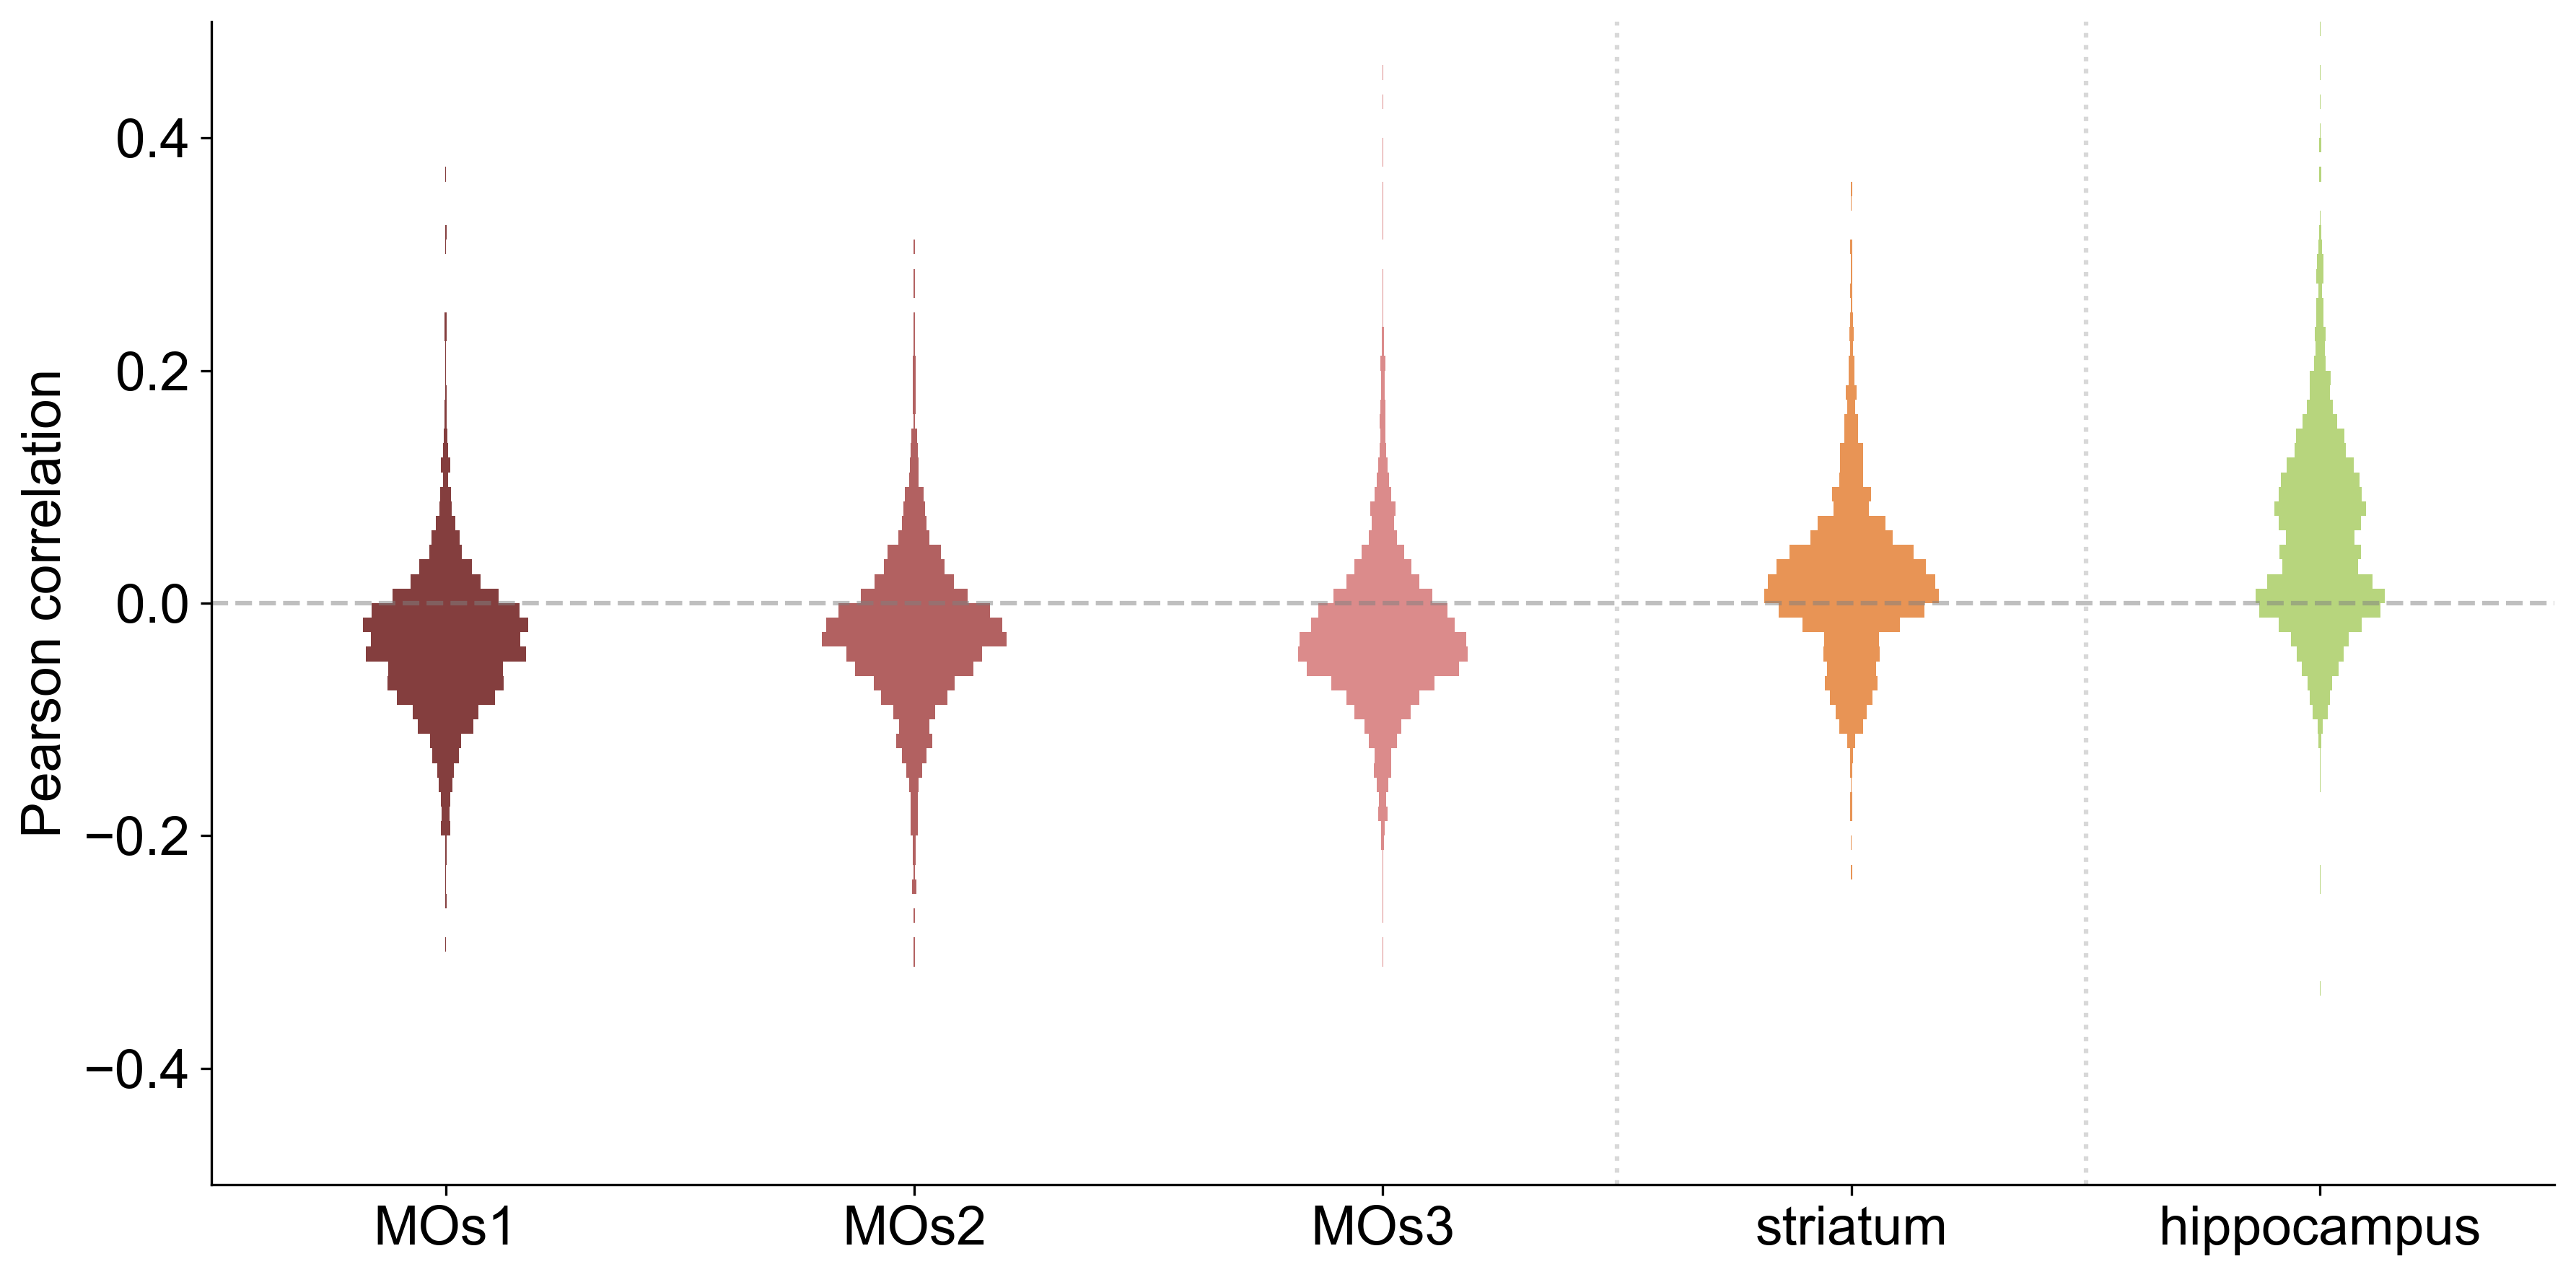

In [392]:
plot_arena_correlation_distributions(results)
plt.savefig(r'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\histograms_arena.svg', 
            bbox_inches='tight', dpi=300)

In [389]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

def plot_wheel_correlation_distributions(all_session_results):
    """Plot wheel correlation distributions for each mouse/brain region."""
    
    # Define colors
    colors = {
        'hippocampus': "#A5CB5D",  
        'striatum': "#E37A2A",
        'MOs(1)': "#660D0D",  # AV043
        'MOs(2)': "#9F3A3A",  # GB011  
        'MOs(3)': "#D26E6E"   # GB012
    }
    
    # Organize data by subject
    data_by_subject = {}
    for result in all_session_results:
        if result.spike_counts is None:
            continue
        
        subject_id = result.metadata.subject_id
        if subject_id not in data_by_subject:
            data_by_subject[subject_id] = []
        
        # Get wheel correlations
        data_by_subject[subject_id].append(result.correlations.wheel)
    
    # For MOs mice (AV043, GB011, GB012), randomly select 3 sessions
    mos_subjects = ['AV043', 'GB011', 'GB012']
    for subject in mos_subjects:
        if subject in data_by_subject:
            n_sessions = len(data_by_subject[subject])
            if n_sessions > 3:
                indices = random.sample(range(n_sessions), 3)
                data_by_subject[subject] = [
                    data_by_subject[subject][i] for i in indices
                ]
    
    # Create single figure with wider aspect ratio
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
    
    # Define order and labels for plotting
    plot_order = [
        ('AV043', 'MOs1', 'MOs(1)'),
        ('GB011', 'MOs2', 'MOs(2)'),
        ('GB012', 'MOs3', 'MOs(3)'),
        ('EB037', 'striatum', 'striatum'),
        ('EB036', 'hippocampus', 'hippocampus')
    ]
    
    positions = []
    labels = []
    spacing = 1.5  # Increased spacing between histograms
    
    for idx, (subject_id, label, color_key) in enumerate(plot_order):
        position = idx * spacing  # Apply spacing multiplier
        
        if subject_id in data_by_subject:
            positions.append(position)
            labels.append(label)
            
            # Pool all correlations from selected sessions
            pooled_correlations = []
            
            for corr in data_by_subject[subject_id]:
                pooled_correlations.extend(corr.flatten())
            
            pooled_correlations = np.array(pooled_correlations)
            
            # Show all correlations
            if len(pooled_correlations) > 0:
                hist, bins = np.histogram(pooled_correlations, bins=70, range=(-0.5, 0.5))
                # Normalize by total neuron count to show proportion
                hist = hist / len(pooled_correlations)
                # Scale for display width
                hist = hist / 0.1 * 0.5  # Slightly wider histograms
                bin_centers = (bins[:-1] + bins[1:]) / 2
                
                for h, b in zip(hist, bin_centers):
                    ax.barh(b, h, left=position-h/2, height=bins[1]-bins[0], 
                            color=colors[color_key], alpha=0.8, edgecolor='none')
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(-0.75, (len(plot_order) - 1) * spacing + 0.75)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Pearson correlation', fontsize=18)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=18)
    
    # Add vertical lines to separate brain regions with adjusted positions
    ax.axvline(2.5 * spacing, color='gray', linestyle=':', alpha=0.3)
    ax.axvline(3.5 * spacing, color='gray', linestyle=':', alpha=0.3)
    
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.tight_layout()
    
 
    


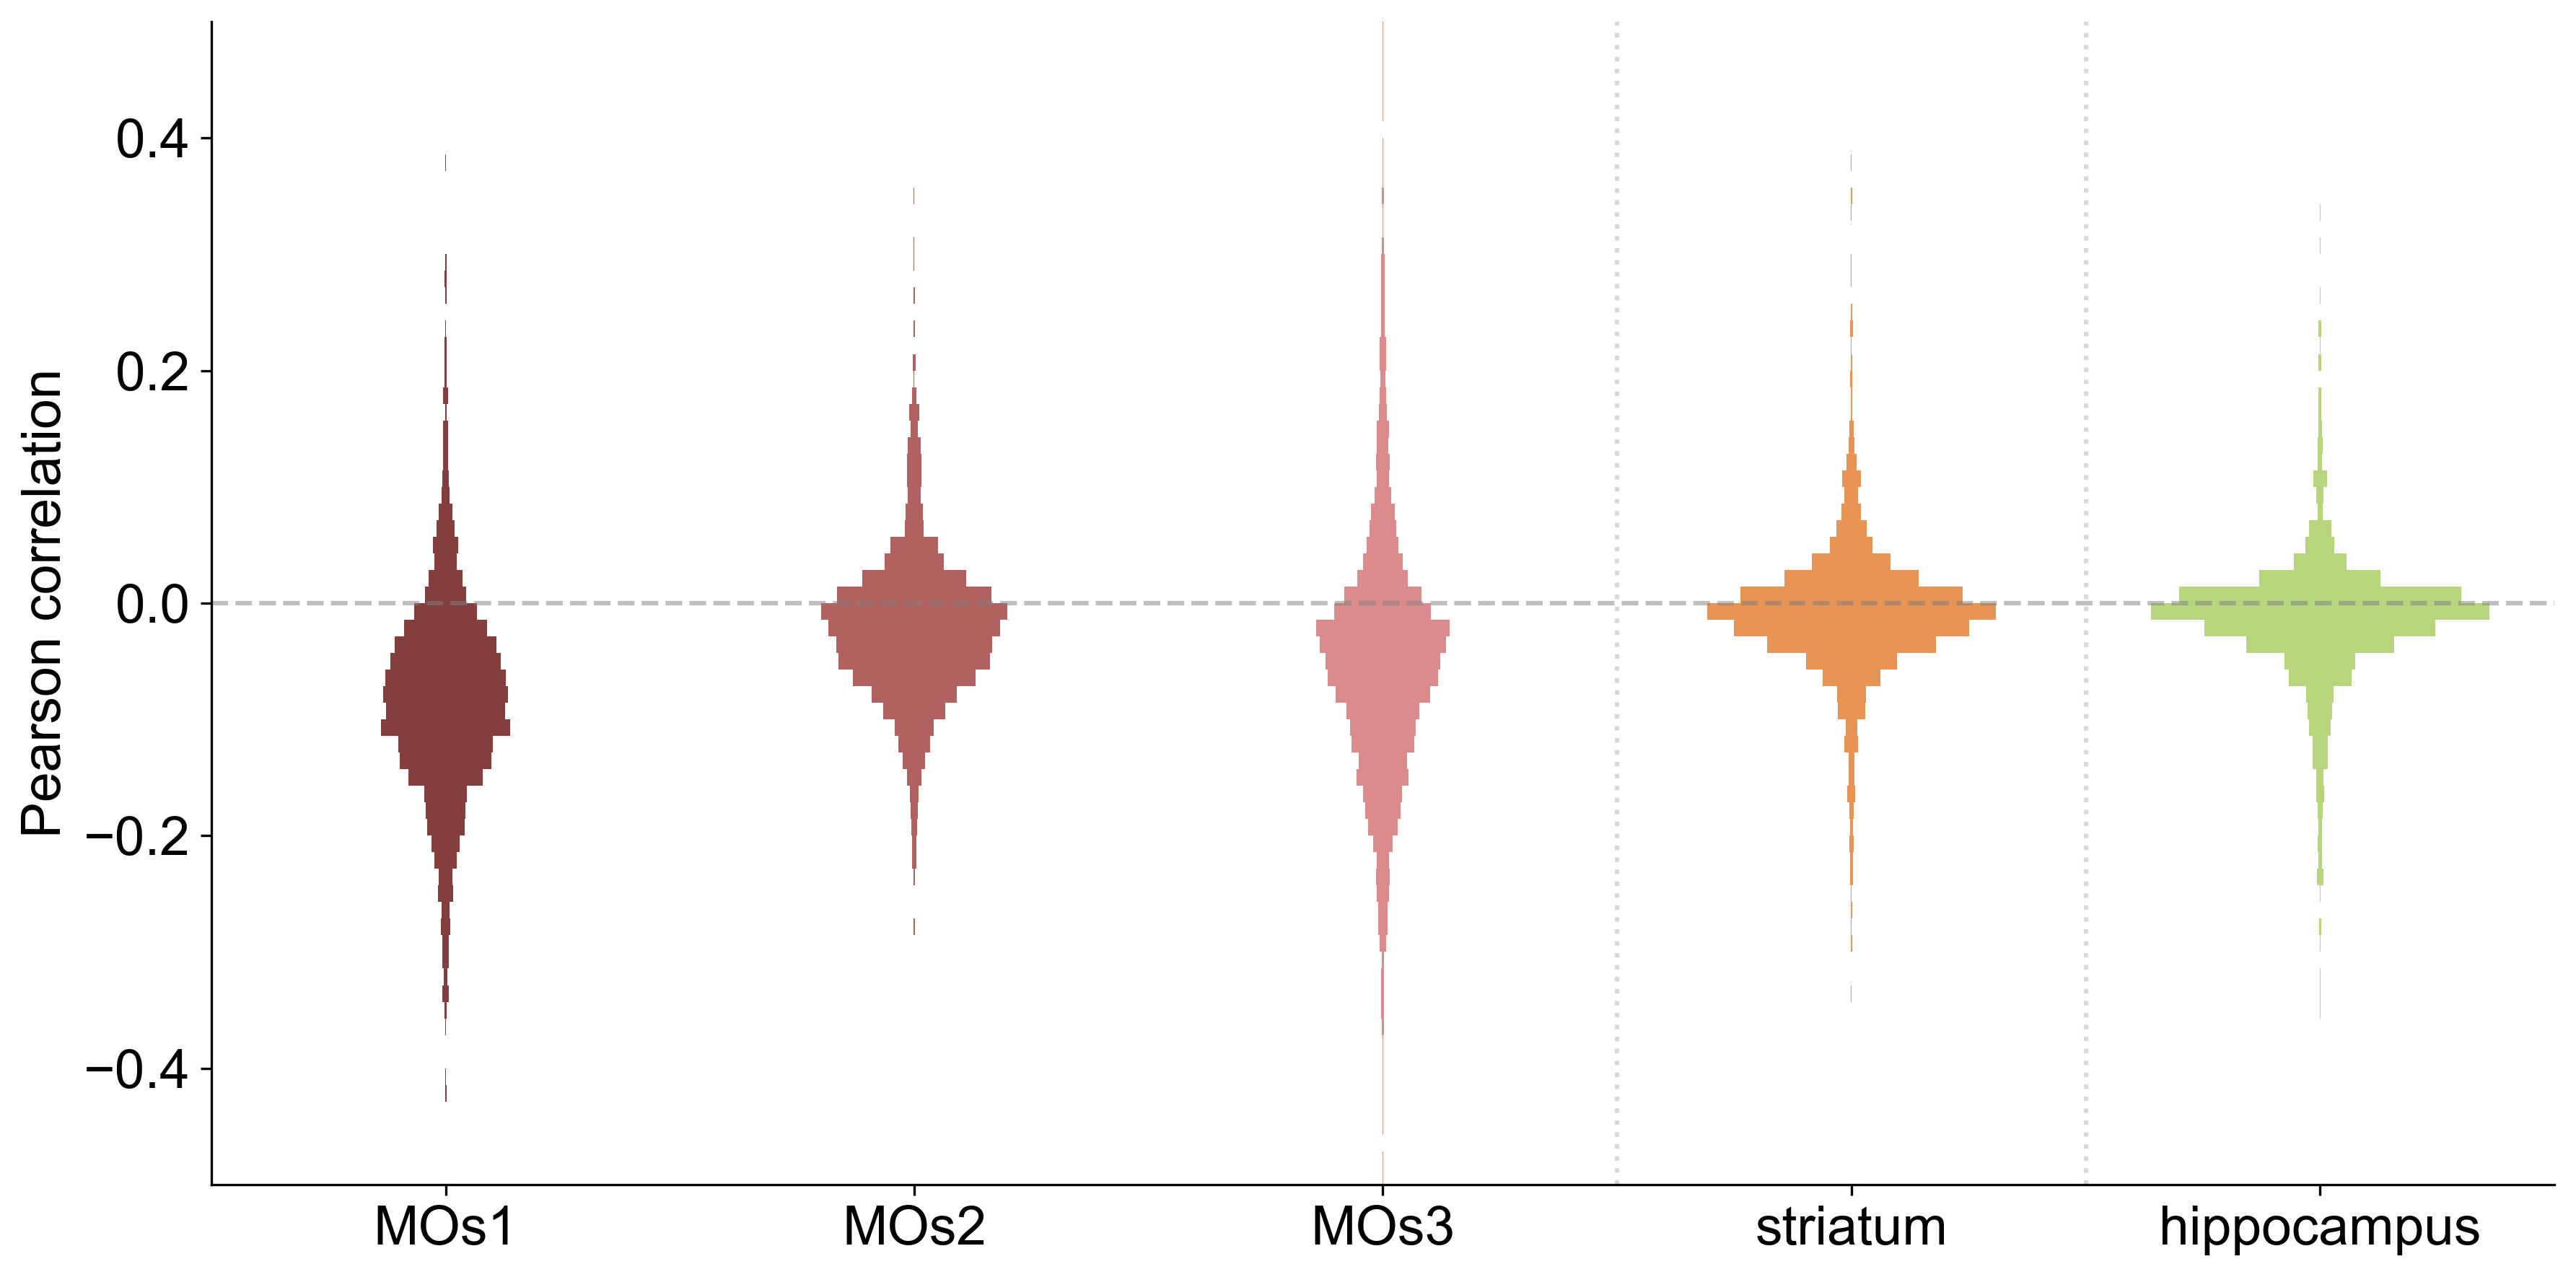

In [390]:
plot_wheel_correlation_distributions(results)
plt.savefig(r'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\histograms_wheel.svg', 
            bbox_inches='tight', dpi=300)

In [121]:
arena_percentages  = []
wheel_percentages = []

for result in results:
        if result.spike_counts is None:
             continue
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        n_neurons= result.spike_counts.shape[0]
        perc_arena= np.sum(sig_arena) / n_neurons * 100
        perc_wheel= np.sum(sig_wheel) / n_neurons * 100

        arena_percentages.append(perc_arena)
        wheel_percentages.append(perc_wheel)
        
       

In [122]:
print(np.median(arena_percentages))
print(np.percentile(arena_percentages, 25))
print(np.percentile(arena_percentages, 75))
print(np.median(wheel_percentages))
print(np.percentile(wheel_percentages, 25))
print(np.percentile(wheel_percentages, 75))

61.35194993722536
47.19600320120516
66.9883564711151
55.27657527657527
32.103672189879084
66.64902447701226


In [ ]:
rels_arena  = []
rels_wheel = []

for result in results:
        if result.spike_counts is None:
             continue
        rel_arena = result.correlations.reliability_arena
        rel_wheel = result.correlations.reliability_wheel

        rels_arena.append(rel_arena)
        rels_wheel.append(rel_wheel)
        

In [140]:
print(np.median(rels_arena))
print(np.percentile(rels_arena, 25))
print(np.percentile(rels_arena, 75))
print(np.median(rels_wheel))
print(np.percentile(rels_wheel, 25))
print(np.percentile(rels_wheel, 75))

from scipy.stats import wilcoxon

statistic_arena, p_value_arena = wilcoxon(rels_arena, alternative='greater')

print(p_value_arena)
print(statistic_arena)

statistic_wheel, p_value_wheel = wilcoxon(rels_wheel, alternative='greater')

print(p_value_wheel)
print(statistic_wheel)

0.8455538663574372
0.7321292330676527
0.8847933623050221
0.8277364511627737
0.6635830560877982
0.8895373808412499
9.5367431640625e-07
210.0
9.5367431640625e-07
210.0


In [141]:
cross_l  = []


for result in results:
        if result.spike_counts is None:
             continue
        cross = result.correlations.cross_context
    

        cross_l.append(cross)
        

In [143]:
print(cross_l)

[0.29200624533922726, 0.2585985614011502, 0.010354111852897056, 0.022178875782319304, 0.0636670200299394, 0.09188125608767593, -4.267621419530604e-05, 0.046445229141453194, 0.10178576742778588, -0.07971060152628161, 0.32083776910091977, 0.22101696511684518, -0.1049920999656428, -0.1937231789711958, -0.07264278099194771, 0.25606731858558, 0.2675871639813749, 0.30061388849689097, 0.34203795007968535, 0.2643982529487086]


In [142]:
print(np.median(cross_l))
print(np.percentile(cross_l, 25))
print(np.percentile(cross_l, 75))

0.0968335117577309
0.007754914836123965
0.26519548070687515


In [1304]:
within_arena  = []
within_wheel= []


for result in results:
        if result.spike_counts is None:
             continue
        arena = result.decoding.performance.arena_to_arena[0,1]
        wheel= result.decoding.performance.wheel_to_wheel[0,1]
    

        within_arena.append(arena)
        within_wheel.append(wheel)

In [1305]:
print(np.mean(within_arena))
print(np.percentile(within_arena, 25))
print(np.percentile(within_arena, 75))
print(np.mean(within_wheel))
print(np.percentile(within_wheel, 25))
print(np.percentile(within_wheel, 75))

0.4187192178009269
0.15956095235235046
0.6401304663124784
0.5828008731152843
0.2804840840126884
0.8534787266468958


In [1291]:
cross_arena  = []
cross_wheel= []


for result in results:
        if result.spike_counts is None:
             continue
        arena = result.decoding.performance.arena_to_wheel[0,1]
        wheel= result.decoding.performance.wheel_to_arena[0,1]
    

        cross_arena.append(arena)
        cross_wheel.append(wheel)

In [1292]:
print(np.mean(cross_arena))
print(np.percentile(cross_arena, 25))
print(np.percentile(cross_arena, 75))
print(np.mean(cross_wheel))
print(np.percentile(cross_wheel, 25))
print(np.percentile(cross_wheel, 75))

0.3521006830673677
0.2084534110227374
0.5226414500984399
-0.016211884841233877
-0.06822324599677976
0.0633432632865968


In [1303]:
print(len(cross_arena))

20


In [393]:
import numpy as np

# Storage for category proportions across sessions
arena_only_props = []
wheel_only_props = []
context_invariant_props = []
context_switching_props = []
non_encoding_props = []

# Loop through all sessions
for result in results:
    # Skip sessions without spike counts
    if result.spike_counts is None:
        continue
    
    # Skip if no permutation test was run
    if not hasattr(result, 'permutation'):
        continue
    
    # Get correlations and significance
    corr_arena = result.correlations.arena
    corr_wheel = result.correlations.wheel
    sig_arena = result.permutation.significant.arena
    sig_wheel = result.permutation.significant.wheel
    
    # Categorize neurons
    context_invariant = sig_arena & sig_wheel & (np.sign(corr_arena) == np.sign(corr_wheel))
    arena_only = sig_arena & ~sig_wheel
    wheel_only = ~sig_arena & sig_wheel
    context_switching = sig_arena & sig_wheel & (np.sign(corr_arena) != np.sign(corr_wheel))
    non_encoding = ~sig_arena & ~sig_wheel
    
    # Calculate proportions
    n_neurons = len(corr_arena)
    arena_only_props.append(100 * np.sum(arena_only) / n_neurons)
    wheel_only_props.append(100 * np.sum(wheel_only) / n_neurons)
    context_invariant_props.append(100 * np.sum(context_invariant) / n_neurons)
    context_switching_props.append(100 * np.sum(context_switching) / n_neurons)
    non_encoding_props.append(100 * np.sum(non_encoding) / n_neurons)

# Calculate median and IQR for each category
categories = {
    'Arena only': arena_only_props,
    'Wheel only': wheel_only_props,
    'Context invariant': context_invariant_props,
    'Context switching': context_switching_props,
    'Non-encoding': non_encoding_props
}

print("\nFunctional Categories (% of neurons):")
print("-" * 50)
for category_name, props in categories.items():
    if len(props) > 0:
        median = np.median(props)
        q1 = np.percentile(props, 25)
        q3 = np.percentile(props, 75)
        print(f"{category_name:18s}: {median:5.1f}% (IQR: {q1:5.1f}% - {q3:5.1f}%)")
    else:
        print(f"{category_name:18s}: No data")

print(f"\nTotal sessions analyzed: {len(arena_only_props)}")


Functional Categories (% of neurons):
--------------------------------------------------
Arena only        :  21.5% (IQR:  18.8% -  33.1%)
Wheel only        :  19.3% (IQR:  10.5% -  27.3%)
Context invariant :  18.5% (IQR:   8.4% -  34.7%)
Context switching :   8.1% (IQR:   5.1% -  11.1%)
Non-encoding      :  21.2% (IQR:  12.1% -  28.9%)

Total sessions analyzed: 20


In [398]:
import numpy as np
import pandas as pd
from scipy import stats

def print_results_statistics(all_session_results):
    """
    Extract and print all statistics reported in the Results section.
    
    Parameters:
    -----------
    all_session_results : list
        List of session results from analyze_all_sessions()
    """
    
    # Filter sessions with neural data - only process sessions with spike counts
    valid_sessions = [r for r in all_session_results if r.spike_counts is not None]
    
    if not valid_sessions:
        print("No sessions with valid neural data found.")
        return
    
    print("="*80)
    print("NEURAL ACTIVITY DURING LOCOMOTION: RESULTS STATISTICS")
    print("="*80)
    
    # ========== 1. NEURAL ENCODING OF LOCOMOTION SPEED ==========
    print("\n1. NEURAL ENCODING OF LOCOMOTION SPEED IS CONTEXT-DEPENDENT")
    print("-"*60)
    
    # Percentage of significant neurons per session
    percent_sig_arena = []
    percent_sig_wheel = []
    
    for session in valid_sessions:
        n_neurons = len(session.permutation.significant.arena)
        percent_sig_arena.append(np.sum(session.permutation.significant.arena) / n_neurons * 100)
        percent_sig_wheel.append(np.sum(session.permutation.significant.wheel) / n_neurons * 100)
    
    print(f"Neurons significantly correlated with speed:")
    print(f"  Arena: median {np.median(percent_sig_arena):.1f}% [IQR: {np.percentile(percent_sig_arena, 25):.2f} - {np.percentile(percent_sig_arena, 75):.2f}%]")
    print(f"  Wheel: median {np.median(percent_sig_wheel):.1f}% [IQR: {np.percentile(percent_sig_wheel, 25):.2f} - {np.percentile(percent_sig_wheel, 75):.2f}%]")
    
    # Within-context reliability
    reliability_arena = [s.correlations.reliability_arena for s in valid_sessions]
    reliability_wheel = [s.correlations.reliability_wheel for s in valid_sessions]
    
    print(f"\nWithin-context reliability (split-half correlations):")
    print(f"  Arena: r = {np.median(reliability_arena):.2f} [IQR: {np.percentile(reliability_arena, 25):.2f}-{np.percentile(reliability_arena, 75):.2f}]")
    print(f"  Wheel: r = {np.median(reliability_wheel):.2f} [IQR: {np.percentile(reliability_wheel, 25):.2f}-{np.percentile(reliability_wheel, 75):.2f}]")
    
    # Cross-context correlations
    cross_context = [s.correlations.cross_context for s in valid_sessions if not np.isnan(s.correlations.cross_context)]
    
    print(f"\nCross-context correlations:")
    print(f"  Arena-Wheel: median r = {np.median(cross_context):.2f} [IQR: {np.percentile(cross_context, 25):.2f}-{np.percentile(cross_context, 75):.2f}]")
    
    # Overall reliability vs stability
    reliability_overall = [s.correlations.reliability for s in valid_sessions]
    stability_overall = [s.correlations.stability for s in valid_sessions]
    
    print(f"\nWithin-context reliability (combined): median r = {np.median(reliability_overall):.2f} [IQR: {np.percentile(reliability_overall, 25):.2f}-{np.percentile(reliability_overall, 75):.2f}]")
    print(f"Cross-context stability: median r = {np.median(stability_overall):.2f} [IQR: {np.percentile(stability_overall, 25):.2f}-{np.percentile(stability_overall, 75):.2f}]")
    
    # Statistical test
    if len(reliability_overall) > 2:
        stat, p_val = stats.wilcoxon(reliability_overall, stability_overall)
        print(f"  Wilcoxon test: p < {p_val:.3f}")
    
    # Functional categories
    print("\nFunctional categories (% of neurons):")
    categories = calculate_functional_categories(valid_sessions)
    for cat_name, percentages in categories.items():
        print(f"  {cat_name}: median {np.median(percentages):.1f}% [IQR: {np.percentile(percentages, 25):.1f}-{np.percentile(percentages, 75):.1f}%]")
    
    # ========== 2. POPULATION CODES ==========
    print("\n2. CONTEXT-DEPENDENT POPULATION CODES FOR LOCOMOTION SPEED")
    print("-"*60)
    
    # Decoding performance
    r2_arena_within = []
    r2_wheel_within = []
    r2_arena_cross = []
    r2_wheel_cross = []
    cosine_sim = []
    
    for session in valid_sessions:
        r2_arena_within.append(session.decoding.performance.arena_to_arena)
        r2_wheel_within.append(session.decoding.performance.wheel_to_wheel)
        r2_arena_cross.append(session.decoding.performance.arena_to_wheel)
        r2_wheel_cross.append(session.decoding.performance.wheel_to_arena)
        cosine_sim.append(session.decoding.weights.cosine_similarity)
    
    print("Within-context decoding performance:")
    print(f"  Arena model → Arena: median r² = {np.median(r2_arena_within):.2f} [IQR: {np.percentile(r2_arena_within, 25):.2f}-{np.percentile(r2_arena_within, 75):.2f}]")
    print(f"  Wheel model → Wheel: median r² = {np.median(r2_wheel_within):.2f} [IQR: {np.percentile(r2_wheel_within, 25):.2f}-{np.percentile(r2_wheel_within, 75):.2f}]")
    
    print("\nCross-context decoding performance:")
    print(f"  Arena model → Wheel: median r² = {np.median(r2_arena_cross):.2f} [IQR: {np.percentile(r2_arena_cross, 25):.2f}-{np.percentile(r2_arena_cross, 75):.2f}]")
    print(f"  Wheel model → Arena: median r² = {np.median(r2_wheel_cross):.2f} [IQR: {np.percentile(r2_wheel_cross, 25):.2f}-{np.percentile(r2_wheel_cross, 75):.2f}]")
    
    print(f"\nDecoder weight similarity:")
    print(f"  Cosine similarity: median = {np.median(cosine_sim):.2f} [IQR: {np.percentile(cosine_sim, 25):.2f}-{np.percentile(cosine_sim, 75):.2f}]")
    
    # ========== 3. REGIONAL DIFFERENCES ==========
    print("\n3. CONTEXT-DEPENDENT ENCODING MANIFESTS DIFFERENTLY ACROSS BRAIN REGIONS")
    print("-"*60)
    
    # Separate by brain region
    mos_sessions = [s for s in valid_sessions if 'GB' in s.metadata.subject_id]
    hpc_sessions = [s for s in valid_sessions if 'EB' in s.metadata.subject_id]
    str_sessions = [s for s in valid_sessions if 'MW' in s.metadata.subject_id]
    
    print_regional_stats("Secondary Motor Cortex", mos_sessions)
    print_regional_stats("Hippocampus", hpc_sessions)
    print_regional_stats("Striatum", str_sessions)
    
    # ========== 4. BEHAVIORAL DIFFERENCES ==========
    print("\n4. BEHAVIORAL DIFFERENCES BETWEEN CONTEXTS")
    print("-"*60)
    
    # Time spent
    time_arena = [s.behavior.summary.occupancy.arena for s in valid_sessions]
    time_wheel = [s.behavior.summary.occupancy.wheel for s in valid_sessions]
    
    print(f"Time spent in each context:")
    print(f"  Arena: {np.mean(time_arena):.1f} ± {np.std(time_arena):.1f}%")
    print(f"  Wheel: {np.mean(time_wheel):.1f} ± {np.std(time_wheel):.1f}%")
    
    stat, p_val = stats.wilcoxon(time_arena, time_wheel)
    print(f"  Wilcoxon test: p = {p_val:.4f}")
    
    # Mean speed
    speed_arena = [s.behavior.summary.mean_speed.arena for s in valid_sessions]
    speed_wheel = [s.behavior.summary.mean_speed.wheel for s in valid_sessions]
    
    print(f"\nMean locomotion speed:")
    print(f"  Arena: {np.mean(speed_arena):.1f} ± {np.std(speed_arena):.1f} cm/s")
    print(f"  Wheel: {np.mean(speed_wheel):.1f} ± {np.std(speed_wheel):.1f} cm/s")
    
    stat, p_val = stats.wilcoxon(speed_arena, speed_wheel)
    print(f"  Wilcoxon test: p = {p_val:.4f}")
    
    # Classification accuracy
    accuracy = [s.behavior.summary.accuracy for s in valid_sessions 
                if not np.isnan(s.behavior.summary.accuracy)]
    
    if accuracy:
        print(f"\nWheel classification accuracy: {np.mean(accuracy)*100:.1f} ± {np.std(accuracy)*100:.1f}%")
    
    print("\n" + "="*80)
    print("END OF RESULTS SUMMARY")
    print("="*80)

def calculate_functional_categories(valid_sessions):
    """Helper function to calculate functional category percentages."""
    categories = {
        'context_invariant': [],
        'arena_only': [],
        'wheel_only': [],
        'context_switching': [],
        'non_encoding': []
    }
    
    for session in valid_sessions:
        sig_arena = session.permutation.significant.arena
        sig_wheel = session.permutation.significant.wheel
        corr_arena = session.correlations.arena
        corr_wheel = session.correlations.wheel
        
        n_neurons = len(sig_arena)
        
        # Calculate categories
        context_inv = sig_arena & sig_wheel & (np.sign(corr_arena) == np.sign(corr_wheel))
        arena_only = sig_arena & ~sig_wheel
        wheel_only = ~sig_arena & sig_wheel
        context_switch = sig_arena & sig_wheel & (np.sign(corr_arena) != np.sign(corr_wheel))
        non_encoding = ~sig_arena & ~sig_wheel
        
        categories['context_invariant'].append(np.sum(context_inv) / n_neurons * 100)
        categories['arena_only'].append(np.sum(arena_only) / n_neurons * 100)
        categories['wheel_only'].append(np.sum(wheel_only) / n_neurons * 100)
        categories['context_switching'].append(np.sum(context_switch) / n_neurons * 100)
        categories['non_encoding'].append(np.sum(non_encoding) / n_neurons * 100)
    
    return categories

def print_regional_stats(region_name, sessions):
    """Helper function to print statistics for a specific brain region."""
    if not sessions:
        return
    
    print(f"\n{region_name} (n={len(sessions)} sessions):")
    
    categories = calculate_functional_categories(sessions)
    
    # For regions with few sessions, print individual values
    if len(sessions) <= 3:
        for cat_name, percentages in categories.items():
            values_str = ", ".join([f"{p:.1f}%" for p in percentages])
            print(f"  {cat_name}: {values_str}")
    else:
        # For regions with more sessions, print median and IQR
        for cat_name, percentages in categories.items():
            print(f"  {cat_name}: median {np.median(percentages):.1f}% [IQR: {np.percentile(percentages, 25):.1f}-{np.percentile(percentages, 75):.1f}%]")
    
    # Print correlation distributions
    all_corr_arena = []
    all_corr_wheel = []
    
    for session in sessions:
        all_corr_arena.extend(session.correlations.arena[~np.isnan(session.correlations.arena)])
        all_corr_wheel.extend(session.correlations.wheel[~np.isnan(session.correlations.wheel)])
    
    print(f"  Arena correlations: mean = {np.mean(all_corr_arena):.3f}, skew = {stats.skew(all_corr_arena):.2f}")
    print(f"  Wheel correlations: mean = {np.mean(all_corr_wheel):.3f}, skew = {stats.skew(all_corr_wheel):.2f}")

# Usage example:
# print_results_statistics(all_session_results)

In [411]:
# 1. Extract Speed Data from sessions that HAVE spike counts
speed_arena = [s.behavior.summary.mean_speed.arena for s in results if s.spike_counts is not None]
speed_wheel = [s.behavior.summary.mean_speed.wheel for s in results if s.spike_counts is not None]

# 2. Extract Occupancy Data from sessions that HAVE spike counts
time_arena = [s.behavior.summary.occupancy.arena for s in results if s.spike_counts is not None]
time_wheel = [s.behavior.summary.occupancy.wheel for s in results if s.spike_counts is not None]

# 3. Calculate and Print Median/IQR for Speed
print("--- Locomotion Speed (from sessions with spike data) ---")
print(f"Arena Speed: median {np.median(speed_arena):.1f} cm/s [IQR: {np.percentile(speed_arena, 25):.1f}-{np.percentile(speed_arena, 75):.1f} cm/s]")
print(f"Wheel Speed: median {np.median(speed_wheel):.1f} cm/s [IQR: {np.percentile(speed_wheel, 25):.1f}-{np.percentile(speed_wheel, 75):.1f} cm/s]")

# 4. Calculate and Print Median/IQR for Occupancy
print("\n--- Time Occupancy (from sessions with spike data) ---")
print(f"Time in Arena: median {np.median(time_arena):.1f}% [IQR: {np.percentile(time_arena, 25):.1f}-{np.percentile(time_arena, 75):.1f}%]")
print(f"Time on Wheel: median {np.median(time_wheel):.1f}% [IQR: {np.percentile(time_wheel, 25):.1f}-{np.percentile(time_wheel, 75):.1f}%]")

--- Locomotion Speed (from sessions with spike data) ---
Arena Speed: median 2.8 cm/s [IQR: 2.3-3.4 cm/s]
Wheel Speed: median 21.5 cm/s [IQR: 18.3-26.6 cm/s]

--- Time Occupancy (from sessions with spike data) ---
Time in Arena: median 72.2% [IQR: 58.1-77.2%]
Time on Wheel: median 27.8% [IQR: 21.4-41.7%]


In [ ]:
print_results_statistics(results)

In [409]:
speed_arena = [s.behavior.summary.mean_speed.arena for s in results if s.behavior and s.behavior.summary]
speed_wheel = [s.behavior.summary.mean_speed.wheel for s in results if s.behavior and s.behavior.summary]

# 2. Extract Occupancy Data
# Creates a list of the proportion of time spent in the arena and wheel
time_arena = [s.behavior.summary.occupancy.arena for s in results if s.behavior and s.behavior.summary]
time_wheel = [s.behavior.summary.occupancy.wheel for s in results if s.behavior and s.behavior.summary]


# 3. Calculate and Print Median/IQR for Speed
print("--- Locomotion Speed ---")
print(f"Arena Speed: median {np.median(speed_arena):.1f} cm/s [IQR: {np.percentile(speed_arena, 25):.1f}-{np.percentile(speed_arena, 75):.1f} cm/s]")
print(f"Wheel Speed: median {np.median(speed_wheel):.1f} cm/s [IQR: {np.percentile(speed_wheel, 25):.1f}-{np.percentile(speed_wheel, 75):.1f} cm/s]")

# 4. Calculate and Print Median/IQR for Occupancy
print("\n--- Time Occupancy ---")
print(f"Time in Arena: median {np.median(time_arena):.1f}% [IQR: {np.percentile(time_arena, 25):.1f}-{np.percentile(time_arena, 75):.1f}%]")
print(f"Time on Wheel: median {np.median(time_wheel):.1f}% [IQR: {np.percentile(time_wheel, 25):.1f}-{np.percentile(time_wheel, 75):.1f}%]")

--- Locomotion Speed ---
Arena Speed: median 2.9 cm/s [IQR: 2.4-3.4 cm/s]
Wheel Speed: median 21.8 cm/s [IQR: 18.0-26.8 cm/s]

--- Time Occupancy ---
Time in Arena: median 72.3% [IQR: 57.3-77.0%]
Time on Wheel: median 27.7% [IQR: 21.3-42.4%]


In [400]:
valid_sessions = [r for r in results if r.spike_counts is not None]

# Extract cross-context split-half correlations
arena1_wheel2_values = []
wheel1_arena2_values = []

for session in valid_sessions:
    # Arena first half vs wheel second half
    corr_arena1_wheel2 = np.corrcoef(
        session.correlations.arena_half1, 
        session.correlations.wheel_half2
    )[0,1]
    arena1_wheel2_values.append(corr_arena1_wheel2)
    
    # Wheel first half vs arena second half  
    corr_wheel1_arena2 = np.corrcoef(
        session.correlations.wheel_half1,
        session.correlations.arena_half2
    )[0,1]
    wheel1_arena2_values.append(corr_wheel1_arena2)

# Print the results
print("\nCross-context split-half correlations:")
print(f"  Arena (1st half) vs Wheel (2nd half): median r = {np.median(arena1_wheel2_values):.2f} [IQR: {np.percentile(arena1_wheel2_values, 25):.2f}-{np.percentile(arena1_wheel2_values, 75):.2f}]")
print(f"  Wheel (1st half) vs Arena (2nd half): median r = {np.median(wheel1_arena2_values):.2f} [IQR: {np.percentile(wheel1_arena2_values, 25):.2f}-{np.percentile(wheel1_arena2_values, 75):.2f}]")


Cross-context split-half correlations:
  Arena (1st half) vs Wheel (2nd half): median r = 0.20 [IQR: 0.03-0.23]
  Wheel (1st half) vs Arena (2nd half): median r = 0.09 [IQR: -0.01-0.24]


In [1306]:
statistic, p_value = wilcoxon(within_arena, cross_arena, alternative='greater')

In [1307]:
print(p_value)

0.06636333465576172


In [1308]:
statistic, p_value = wilcoxon(within_wheel, cross_wheel, alternative='greater')

In [1314]:
statistic, p_value = wilcoxon(cross_wheel, alternative='greater')
print(p_value)

0.4927177429199219


In [1315]:
statistic, p_value = wilcoxon(cross_arena, alternative='greater')
print(p_value)

9.5367431640625e-07


In [ ]:
rels  = []
stabs = []

for result in results:
        if result.spike_counts is None:
             continue
        rel = result.correlations.reliability
        stab = result.correlations.stability

        rels.append(rel)
        stabs.append(stab)

In [146]:
print(np.median(rels))
print(np.percentile(rels, 25))
print(np.percentile(rels, 75))

print(np.median(stabs))
print(np.percentile(stabs, 25))
print(np.percentile(stabs, 75))

0.7994504406196894
0.7047878924106159
0.8726475660887395
0.11649100789448637
0.009279026484100885
0.2540673939599422


In [147]:
statistic, p_value = wilcoxon(rels, stabs, alternative='greater')

In [1372]:
time = []

for result in results:
        if result.spike_counts is None:
             continue
        total_time = (len(result.behavior.mask_arena) * result.metadata.bin_width) / 60

        time.append(total_time)
       

In [1375]:
print(np.mean(time))
print(np.std(time))

56.506083333333336
19.311333720807298


In [1428]:
arena_pos_mo = []
wheel_pos_mo = []
arena_neg_mo= []
wheel_neg_mo= []
arena_total_mo=[]
wheel_total_mo = []




for result in results:
        if result.spike_counts is None:
             continue
        
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        if result.metadata.subject_id[:2] == 'EB':
            continue
        else:
          arena_total_mo.append(np.sum(sig_arena))
          wheel_total_mo.append(np.sum(sig_wheel))

        
        


        

In [1429]:
print(np.median(arena_total_mo))
print(np.percentile(arena_total_mo, 25))
print(np.percentile(arena_total_mo, 75))
print(np.median(wheel_total_mo))
print(np.percentile(wheel_total_mo, 25))
print(np.percentile(wheel_total_mo, 75))



464.0
377.5
962.0
553.0
432.0
971.5


In [1430]:
statistic_mo, p_value_mo = wilcoxon(arena_total_mo, wheel_total_mo, alternative='greater')

In [1431]:
print(p_value_mo)

0.83709716796875


In [1432]:
arena_pos_hc = []
wheel_pos_hc = []
arena_neg_hc= []
wheel_neg_hc= []
arena_total_hc=[]
wheel_total_hc = []




for result in results:
        if result.spike_counts is None:
             continue
        
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        if result.metadata.subject_id == 'EB036':
            arena_total_hc.append(np.sum(sig_arena))
            wheel_total_hc.append(np.sum(sig_wheel))
        else:
              continue
          

In [1434]:
print(np.median(arena_total_hc))
print(np.percentile(arena_total_hc, 25))
print(np.percentile(arena_total_hc, 75))
print(np.median(wheel_total_hc))
print(np.percentile(wheel_total_hc, 25))
print(np.percentile(wheel_total_hc, 75))

379.0
375.0
398.5
148.0
123.0
160.0


In [1435]:
statistic_hc, p_value_hc = wilcoxon(arena_total_hc, wheel_total_hc, alternative='greater')

In [1436]:
print(p_value_hc)

0.125


In [ ]:
arena_pos_sc = []
wheel_pos_sc = []
arena_neg_sc= []
wheel_neg_sc= []
arena_total_sc=[]
wheel_total_sc = []




for result in results:
        if result.spike_counts is None:
             continue
        
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        pos_sig_arena = sig_arena & (result.correlations.arena > 0)
        neg_sig_arena= sig_wheel & (result.correlations.arena < 0)

        pos_sig_wheel = sig_wheel & (result.correlations.wheel > 0)
        neg_sig_arena`_sig_wheel = sig_wheel & (result.correlations.wheel > 0)

        if result.metadata.subject_id == 'EB037':
            arena_total_sc.append(np.sum(sig_arena))
            wheel_total_sc.append(np.sum(sig_wheel))
            arena_pos_sc.append(np.sum(pos_sig_arena))
            arena_neg_sc.append(np.sum(pos_sig_arena))
            wheel_pos_sc.append(np.sum(pos_sig_wheel))
        else:
              continue

In [1438]:
print(np.median(arena_total_sc))
print(np.percentile(arena_total_sc, 25))
print(np.percentile(arena_total_sc, 75))
print(np.median(wheel_total_sc))
print(np.percentile(wheel_total_sc, 25))
print(np.percentile(wheel_total_sc, 75))

356.0
257.5
449.5
137.0
96.5
204.5


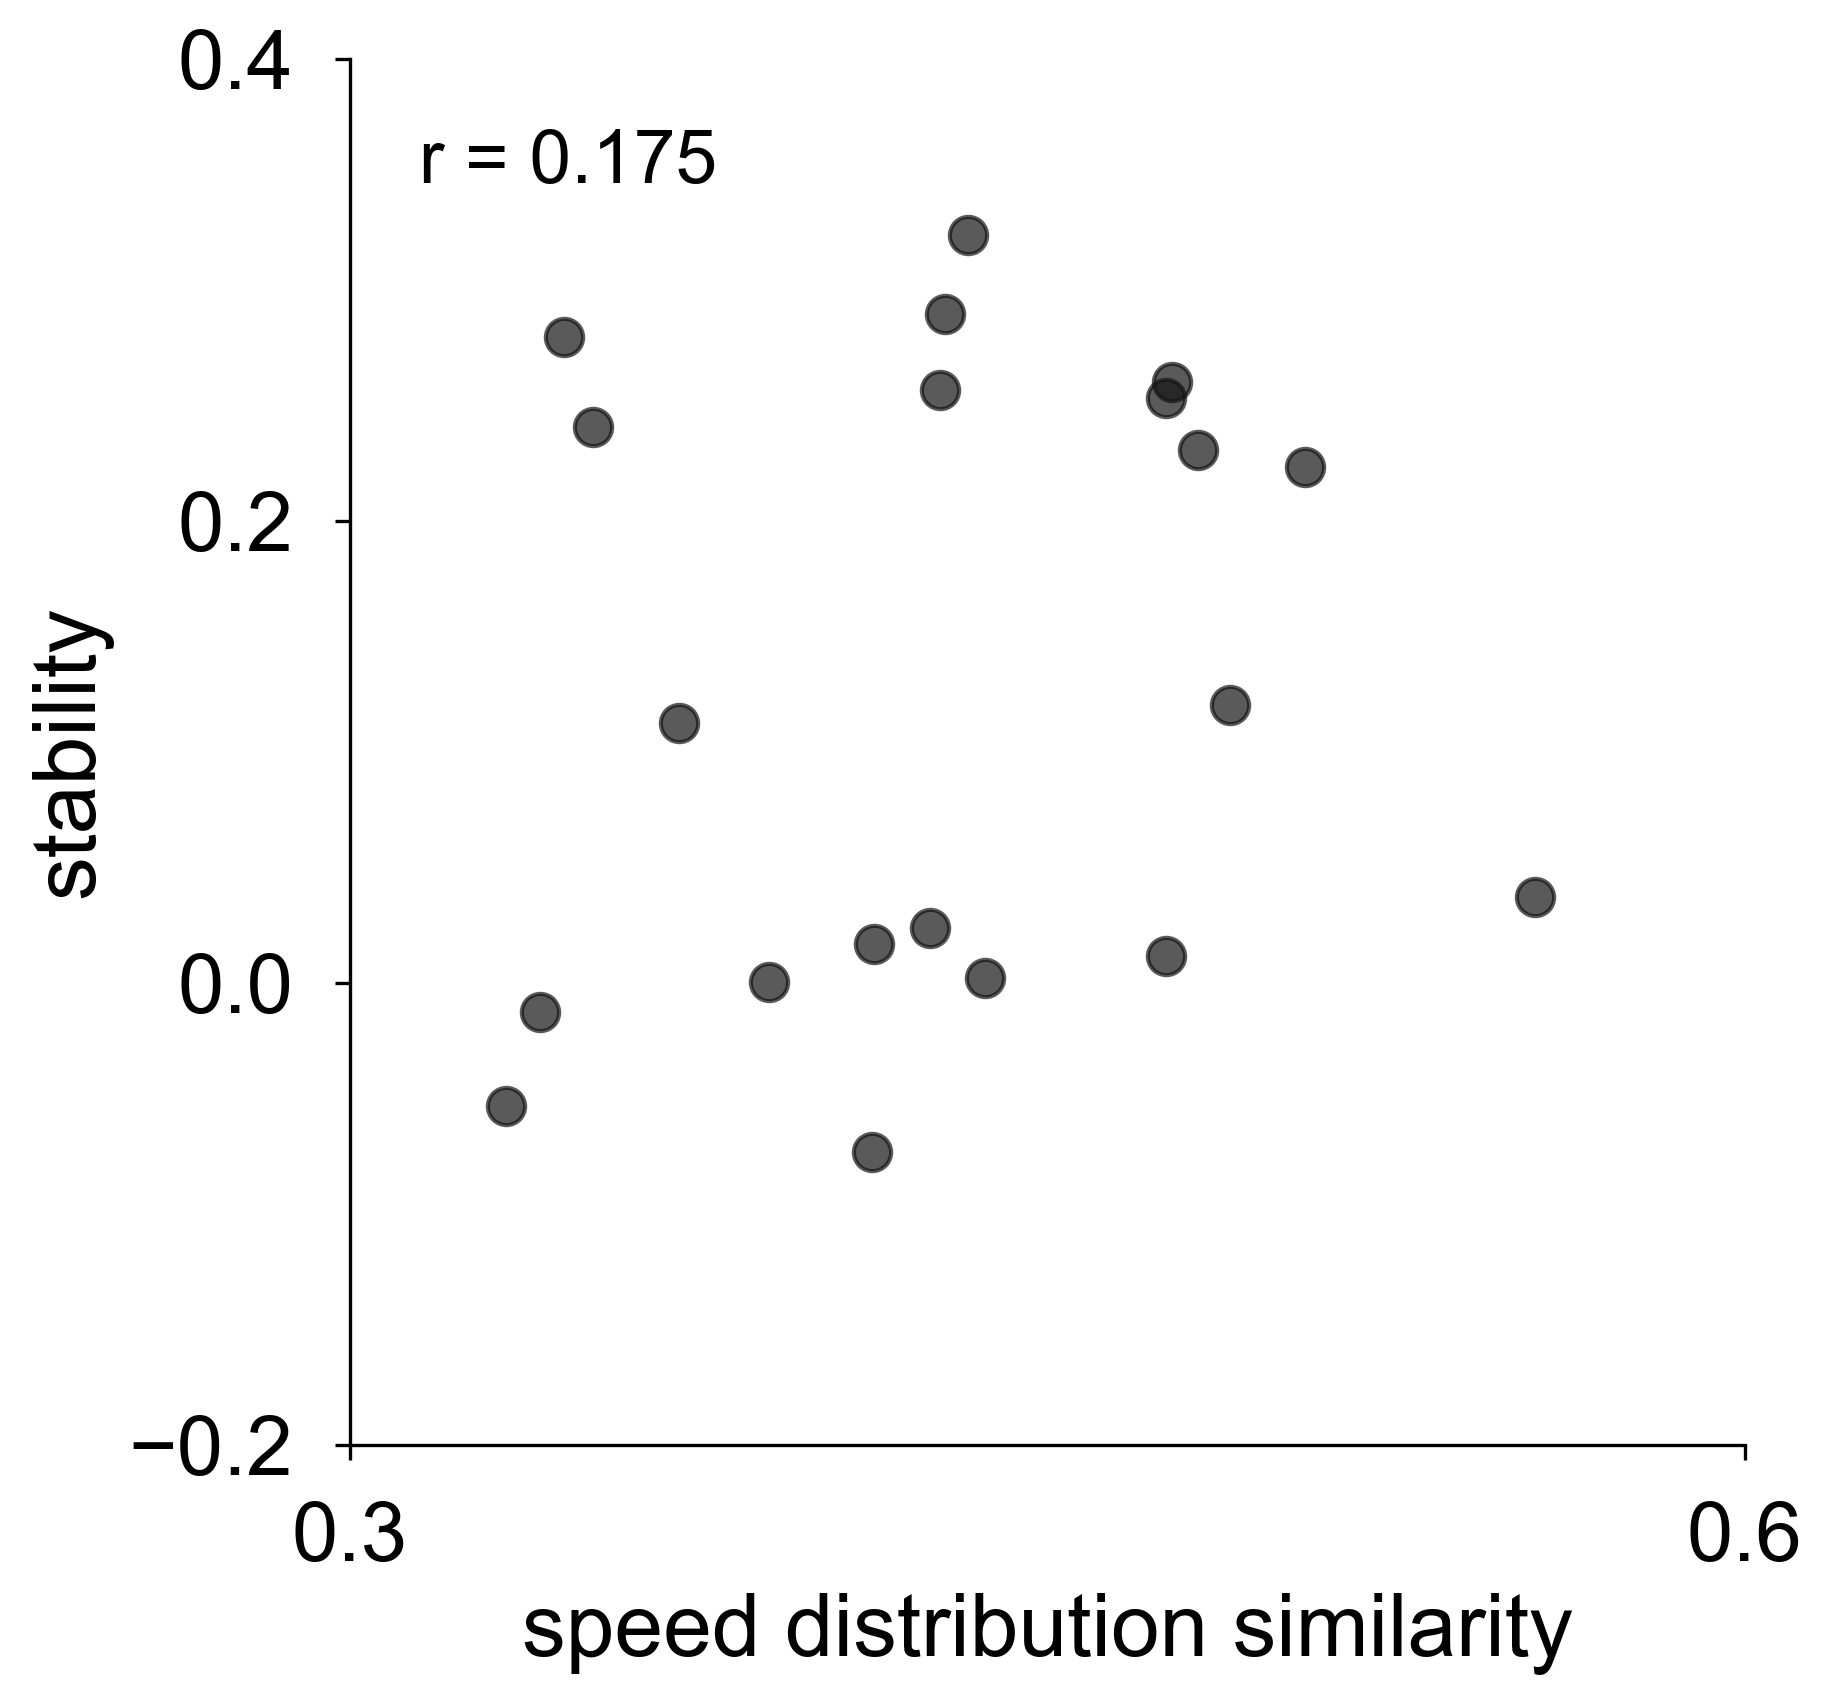

In [204]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# Storage for all sessions
distribution_similarities = []
median_stabilities = []

# Process each session
for session in results:
    
    # Check if session has spike counts and correlation results
    if session.spike_counts is None or session.correlations is None:
        continue
    
    # Check if stability is valid (not NaN)
    if np.isnan(session.correlations.stability):
        continue
    
    # Get speed data for each context
    speed_arena = session.behavior.speed_arena[session.behavior.mask_arena]
    speed_wheel = session.behavior.speed_wheel[session.behavior.mask_wheel]
    
    # Make sure we have data in both contexts
    if len(speed_arena) == 0 or len(speed_wheel) == 0:
        continue
    
    # Create histograms with shared bins
    all_speeds = np.concatenate([speed_arena, speed_wheel])
    bins = np.linspace(0, np.percentile(all_speeds, 99), 50)
    
    hist_arena, _ = np.histogram(speed_arena, bins=bins, density=True)
    hist_wheel, _ = np.histogram(speed_wheel, bins=bins, density=True)
    
    # Add small epsilon to avoid zeros
    hist_arena = hist_arena + 1e-10
    hist_wheel = hist_wheel + 1e-10
    
    # Normalize
    hist_arena = hist_arena / np.sum(hist_arena)
    hist_wheel = hist_wheel / np.sum(hist_wheel)
    
    # Calculate JS divergence
    js_divergence = jensenshannon(hist_arena, hist_wheel)
    distribution_similarity = 1 - js_divergence
    
    # Store results
    distribution_similarities.append(distribution_similarity)
    median_stabilities.append(session.correlations.stability)

# Plotting with your aesthetic preferences
plt.rcParams['font.sans-serif'] = ['Arial']

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

# Scatter plot
ax.scatter(distribution_similarities, median_stabilities, 
          alpha=0.7, color="#141414", zorder=2, s=80)

# Calculate correlation for annotation (optional)
r = np.corrcoef(distribution_similarities, median_stabilities)[0,1]

# Labels
ax.set_xlabel('speed distribution similarity', fontsize=21)
ax.set_ylabel('stability', fontsize=21)

# Set axis limits (adjust based on your data range)
ax.set_xlim(0.3, 0.6)  # JS similarity is bounded 0-1
ax.set_ylim(-0.2, 0.4)  # Adjust based on your stability range

# Set ticks
ax.set_xticks(np.arange(0.3, 0.61, 0.3))
ax.set_yticks(np.arange(-0.2, 0.4, 0.2))
ax.tick_params(axis='both', labelsize=20, pad=10)

# Remove top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Add correlation as text (optional - you might not want this either)


ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes, 
        fontsize=18, verticalalignment='top')

# Save figure
plt.savefig(r'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\distribution_similarity_vs_stability.svg', 
            bbox_inches='tight', dpi=300)

plt.show()


In [383]:
result= results[11]
corr_arena= result.correlations.arena
corr_wheel= result.correlations.wheel
sig_arena= result.permutation.significant.arena
sig_wheel=result.permutation.significant.wheel

In [384]:
categories = categorise_neurons(corr_arena, corr_wheel, sig_arena, sig_wheel)

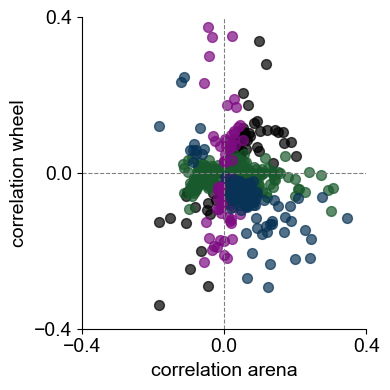

In [385]:

labels = ['Context invariant', 'Arena only', 'Wheel only', 'Context switching']
colors = ["#000000", '#195A2C', '#7D0C81', '#083356']
category_fields = [categories.context_invariant, categories.arena_only, categories.wheel_only, categories.context_switching]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the data for each category with its specific color
for i in range(len(labels)):
    # Get the boolean mask for the current category
    mask = category_fields[i]
    
    # Use the mask to select the relevant data points
    ax.scatter(corr_arena[mask], corr_wheel[mask], 
               c=colors[i], label=labels[i], alpha=0.7, s=50)


ax.set_xlabel('correlation arena', fontsize=14)
ax.set_ylabel('correlation wheel', fontsize=14)




# Optional: Add lines to indicate zero correlation
ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.8, linestyle='--')
ax.set_xticks(np.arange(-0.4, 0.41, 0.4))

ax.set_yticks(np.arange(-0.4, 0.41, 0.4))
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.4, 0.4)
ax.tick_params(axis='both', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_thesis\categories_ST.svg', 
            bbox_inches='tight', dpi=300)

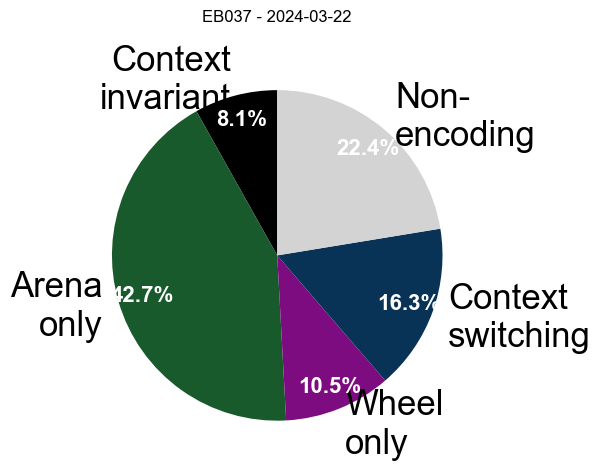

In [386]:
# Extract counts from your categories bunch
counts = [
    np.sum(categories.context_invariant),
    np.sum(categories.arena_only),
    np.sum(categories.wheel_only),
    np.sum(categories.context_switching),
    np.sum(categories.non_encoding)
]

labels = ['Context\ninvariant', 'Arena\nonly', 'Wheel\nonly', 'Context\nswitching', 'Non-\nencoding']
colors = ["#000000", '#195A2C', '#7D0C81', '#083356', '#D3D3D3']

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%',
                                   startangle=90, pctdistance=0.85,
                                   textprops={'fontsize': 500})  # Increased from 10 to 14

# Make percentage text bold and bigger
for autotext in autotexts:
    autotext.set_weight('bold')
    autotext.set_color('white')
    autotext.set_fontsize(16)  # Set percentage font size explicitly

# Make label text bigger
for text in texts:
    text.set_fontsize(25)  # Set label font size explicitly

ax.set_title(f'{result.metadata.subject_id} - {result.metadata.date}', fontsize=12, pad=20)
plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_thesis\pie_ST.svg')


In [2549]:
ci = []
ao = []
wo= []
cs= []
ne= []

for result in results:
    if result.spike_counts is None:
             continue
    
    if result.metadata.subject_id[:2] == "EB":
    
        context_inv = np.sum(categories.context_invariant) / result.spike_counts.shape[0] * 100,
        arena_only = np.sum(categories.arena_only) / result.spike_counts.shape[0] * 100,
        wheel_only =np.sum(categories.wheel_only) / result.spike_counts.shape[0] * 100,
        context_swi =np.sum(categories.context_switching) / result.spike_counts.shape[0]* 100,
        non_encoding=np.sum(categories.non_encoding)  / result.spike_counts.shape[0] * 100
        
        ci.append(context_inv)
        ao.append(arena_only)
        wo.append(wheel_only)
        cs.append(context_swi)
        ne.append(non_encoding)
    
    else:
          continue




In [2550]:
print(ci)


[(11.380597014925373,), (9.902597402597403,), (10.645724258289704,), (9.45736434108527,), (10.815602836879433,), (7.512315270935961,)]


In [ ]:
plt.scatter(corr_arena, corr_wheel)

In [48]:
i=19
spike_counts = results[i].spike_counts
speed_arena = results[i].behavior.speed_arena
speed_wheel = results[i].behavior.speed_wheel
mask_arena = results[i].behavior.mask_arena
mask_wheel = results[i].behavior.mask_wheel
corr_arena = results[i].correlations.arena
corr_wheel = results[i].correlations.wheel
sig_arena = results[i].permutation.significant.arena
sig_wheel = results[i].permutation.significant.wheel

In [49]:
max_speed_arena = np.nanmax(speed_arena[mask_arena])
max_speed_wheel = np.nanmax(speed_wheel[mask_wheel])

# Create bins with same width
bin_width = 2.0  # cm/s
arena_bins = np.arange(0, max_speed_arena + bin_width, bin_width)
wheel_bins = np.arange(0, max_speed_wheel + bin_width, bin_width)

# Compute tuning curves
arena_centers, oa_tuning, oa_sem = compute_speed_tuning(
    spike_counts, speed_arena, mask_arena, arena_bins)
wheel_centers, wh_tuning, wh_sem = compute_speed_tuning(
    spike_counts, speed_wheel, mask_wheel, wheel_bins)

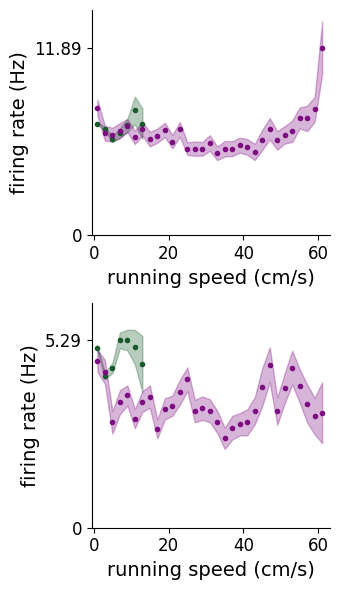

In [50]:
# Fix the correlation assignment first
corr_arena = results[i].correlations.arena  # Fixed: use .arena, not .wheel
corr_wheel = results[i].correlations.wheel

# Identify arena-only neurons (significant in arena, not in wheel)
arena_only_mask = ~sig_arena & ~sig_wheel
arena_only_indices = np.where(arena_only_mask)[0]

# Get correlations for arena-only neurons
arena_only_corr = corr_arena[arena_only_mask]

# Define percentiles to plot - only 100th and 75th
percentiles = [50, 25]

# Create 2x1 subplot (vertically stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 6))

for idx, pct in enumerate(percentiles):
    ax = axes[idx]
    
    # Find the percentile value among arena-only neurons
    percentile_value = np.percentile(np.abs(arena_only_corr), pct)
    
    # Find which arena-only neuron is closest to this percentile
    idx_in_arena_only = np.argmin(np.abs(np.abs(arena_only_corr) - percentile_value))
    neuron_idx = arena_only_indices[idx_in_arena_only]
    
    # Get max rate for this neuron
    max_rate = max(np.nanmax(oa_tuning[neuron_idx, :]), 
                   np.nanmax(wh_tuning[neuron_idx, :]))
    
    # Plot arena with shaded error region
    ax.fill_between(arena_centers, 
                    oa_tuning[neuron_idx, :] - oa_sem[neuron_idx, :],
                    oa_tuning[neuron_idx, :] + oa_sem[neuron_idx, :],
                    color='#195A2C', alpha=0.3)
    ax.plot(arena_centers, oa_tuning[neuron_idx, :], 
            'o', color='#195A2C', markersize=3)
    
    # Plot wheel with shaded error region
    ax.fill_between(wheel_centers, 
                    wh_tuning[neuron_idx, :] - wh_sem[neuron_idx, :],
                    wh_tuning[neuron_idx, :] + wh_sem[neuron_idx, :],
                    color='#7D0C81', alpha=0.3)
    ax.plot(wheel_centers, wh_tuning[neuron_idx, :], 
            'o', color='#7D0C81', markersize=3)
    
    # Styling
    ax.set_xlabel('running speed (cm/s)', fontsize=14)
    ax.set_ylabel('firing rate (Hz)', fontsize=14)
    
    # Format y-axis with rounded max value
    max_rate_rounded = round(max_rate, 2)
    ax.set_yticks([0, max_rate_rounded])
    ax.set_yticklabels(['0', f'{max_rate_rounded:.2f}'])
    
    ax.set_xlim(-0.5, max(max_speed_arena, max_speed_wheel) + 0.5)
    ax.set_ylim(0, max_rate * 1.2)  # Add 30% padding above max
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=12)

#axes[1].set_ylim(0, max_rate * 1.5)  # Add 30% padding above max

plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_thesis\non_encoding_GB.svg', 
            bbox_inches='tight', dpi=300)

In [1144]:
data = results[21]
speed_arena = data.behavior.speed_arena
speed_wheel = data.behavior.speed_wheel
mask_arena = data.behavior.mask_arena
mask_wheel = data.behavior.mask_wheel
spike_counts = data.spike_counts
corr_arena = data.correlations.arena
corr_wheel = data.correlations.wheel

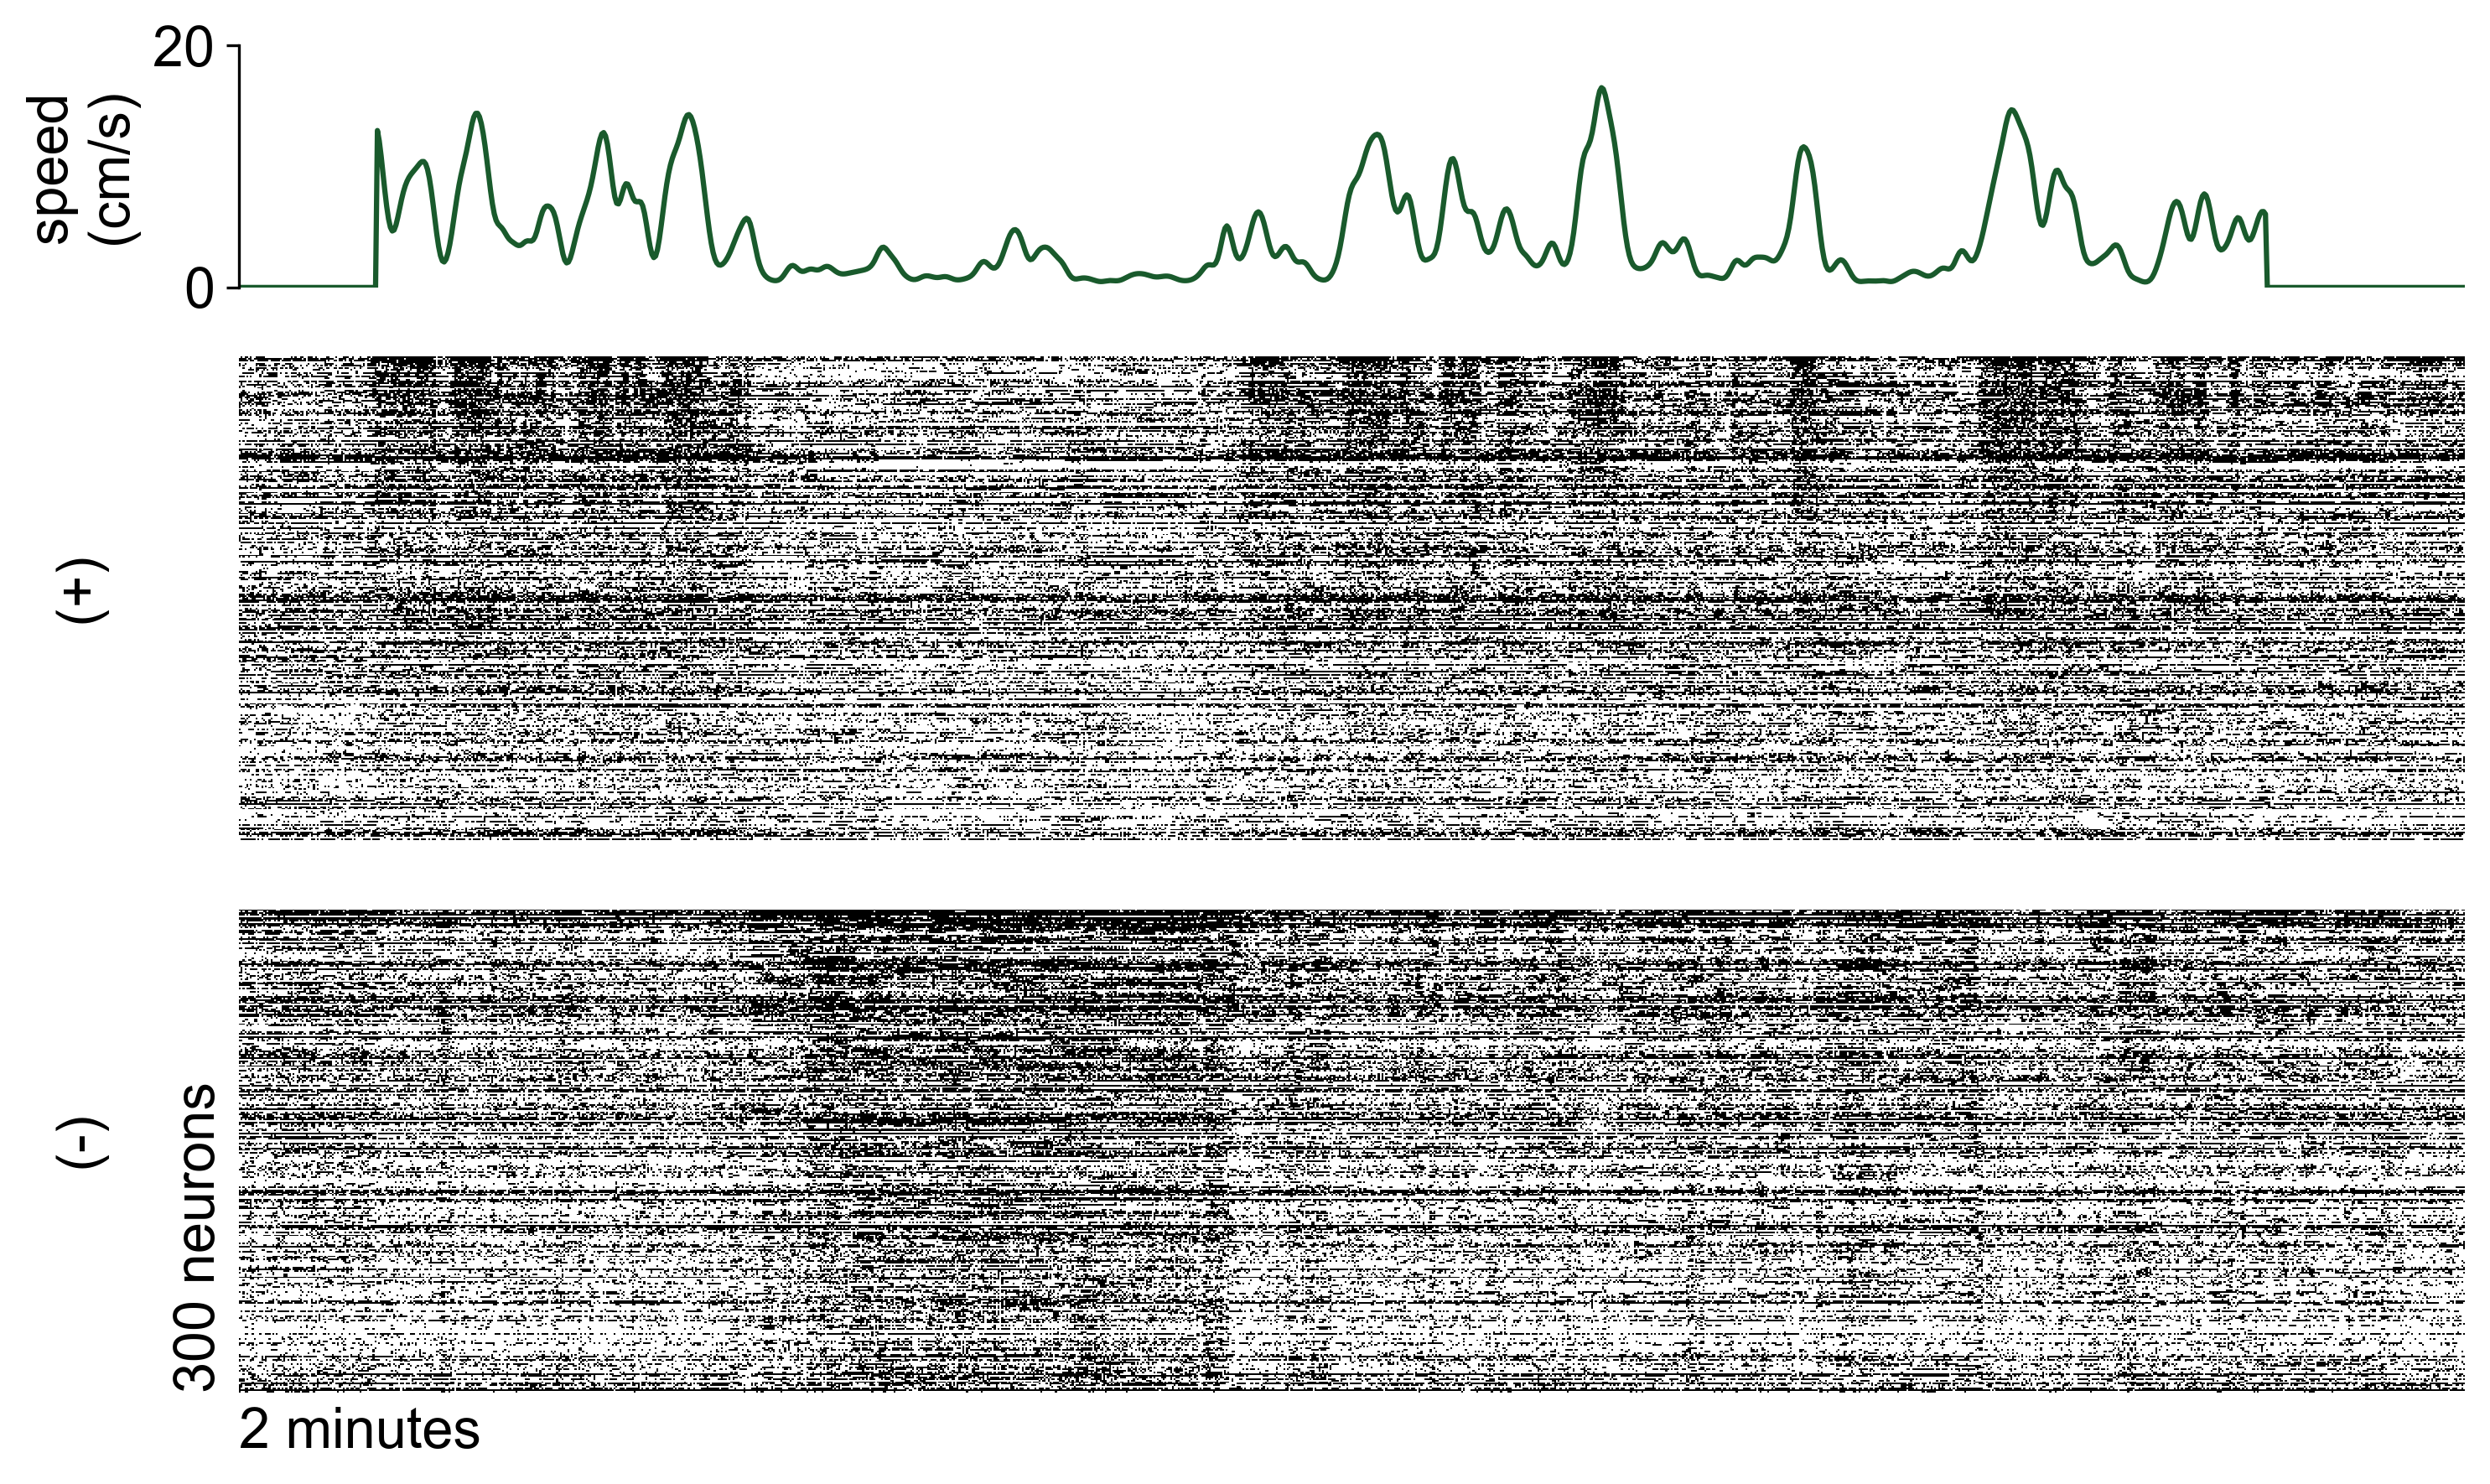

In [1189]:
plot_raster_pos_neg(spike_counts, speed_arena, mask_arena, corr_arena, color="#195A2C", n_neurons=300, w_start=3600, w_end=4800, save_path='arena_raster_300_neurons', save=True)

In [958]:
print(sessions)

[('AV043', '2024-03-04'), ('AV043', '2024-03-05'), ('AV043', '2024-03-12'), ('AV043', '2024-03-13'), ('AV043', '2024-03-14'), ('AV043', '2024-03-26'), ('EB036', '2024-03-15'), ('EB036', '2024-03-19'), ('EB036', '2024-03-20'), ('EB036', '2024-03-22'), ('EB037', '2024-03-20'), ('EB037', '2024-03-21'), ('EB037', '2024-03-22'), ('GB011', '2024-05-09'), ('GB011', '2024-05-14'), ('GB011', '2024-05-15'), ('GB011', '2024-05-16'), ('GB011', '2024-05-17'), ('GB012', '2024-06-19'), ('GB012', '2024-06-20'), ('GB012', '2024-06-21'), ('GB012', '2024-06-25'), ('GB012', '2024-07-11'), ('GB012', '2024-07-16')]


In [1146]:
i=21
spike_counts = results[i].spike_counts
speed_arena = results[i].behavior.speed_arena
speed_wheel = results[i].behavior.speed_wheel
mask_arena = results[i].behavior.mask_arena
mask_wheel = results[i].behavior.mask_wheel
corr_wheel = results[i].correlations.wheel

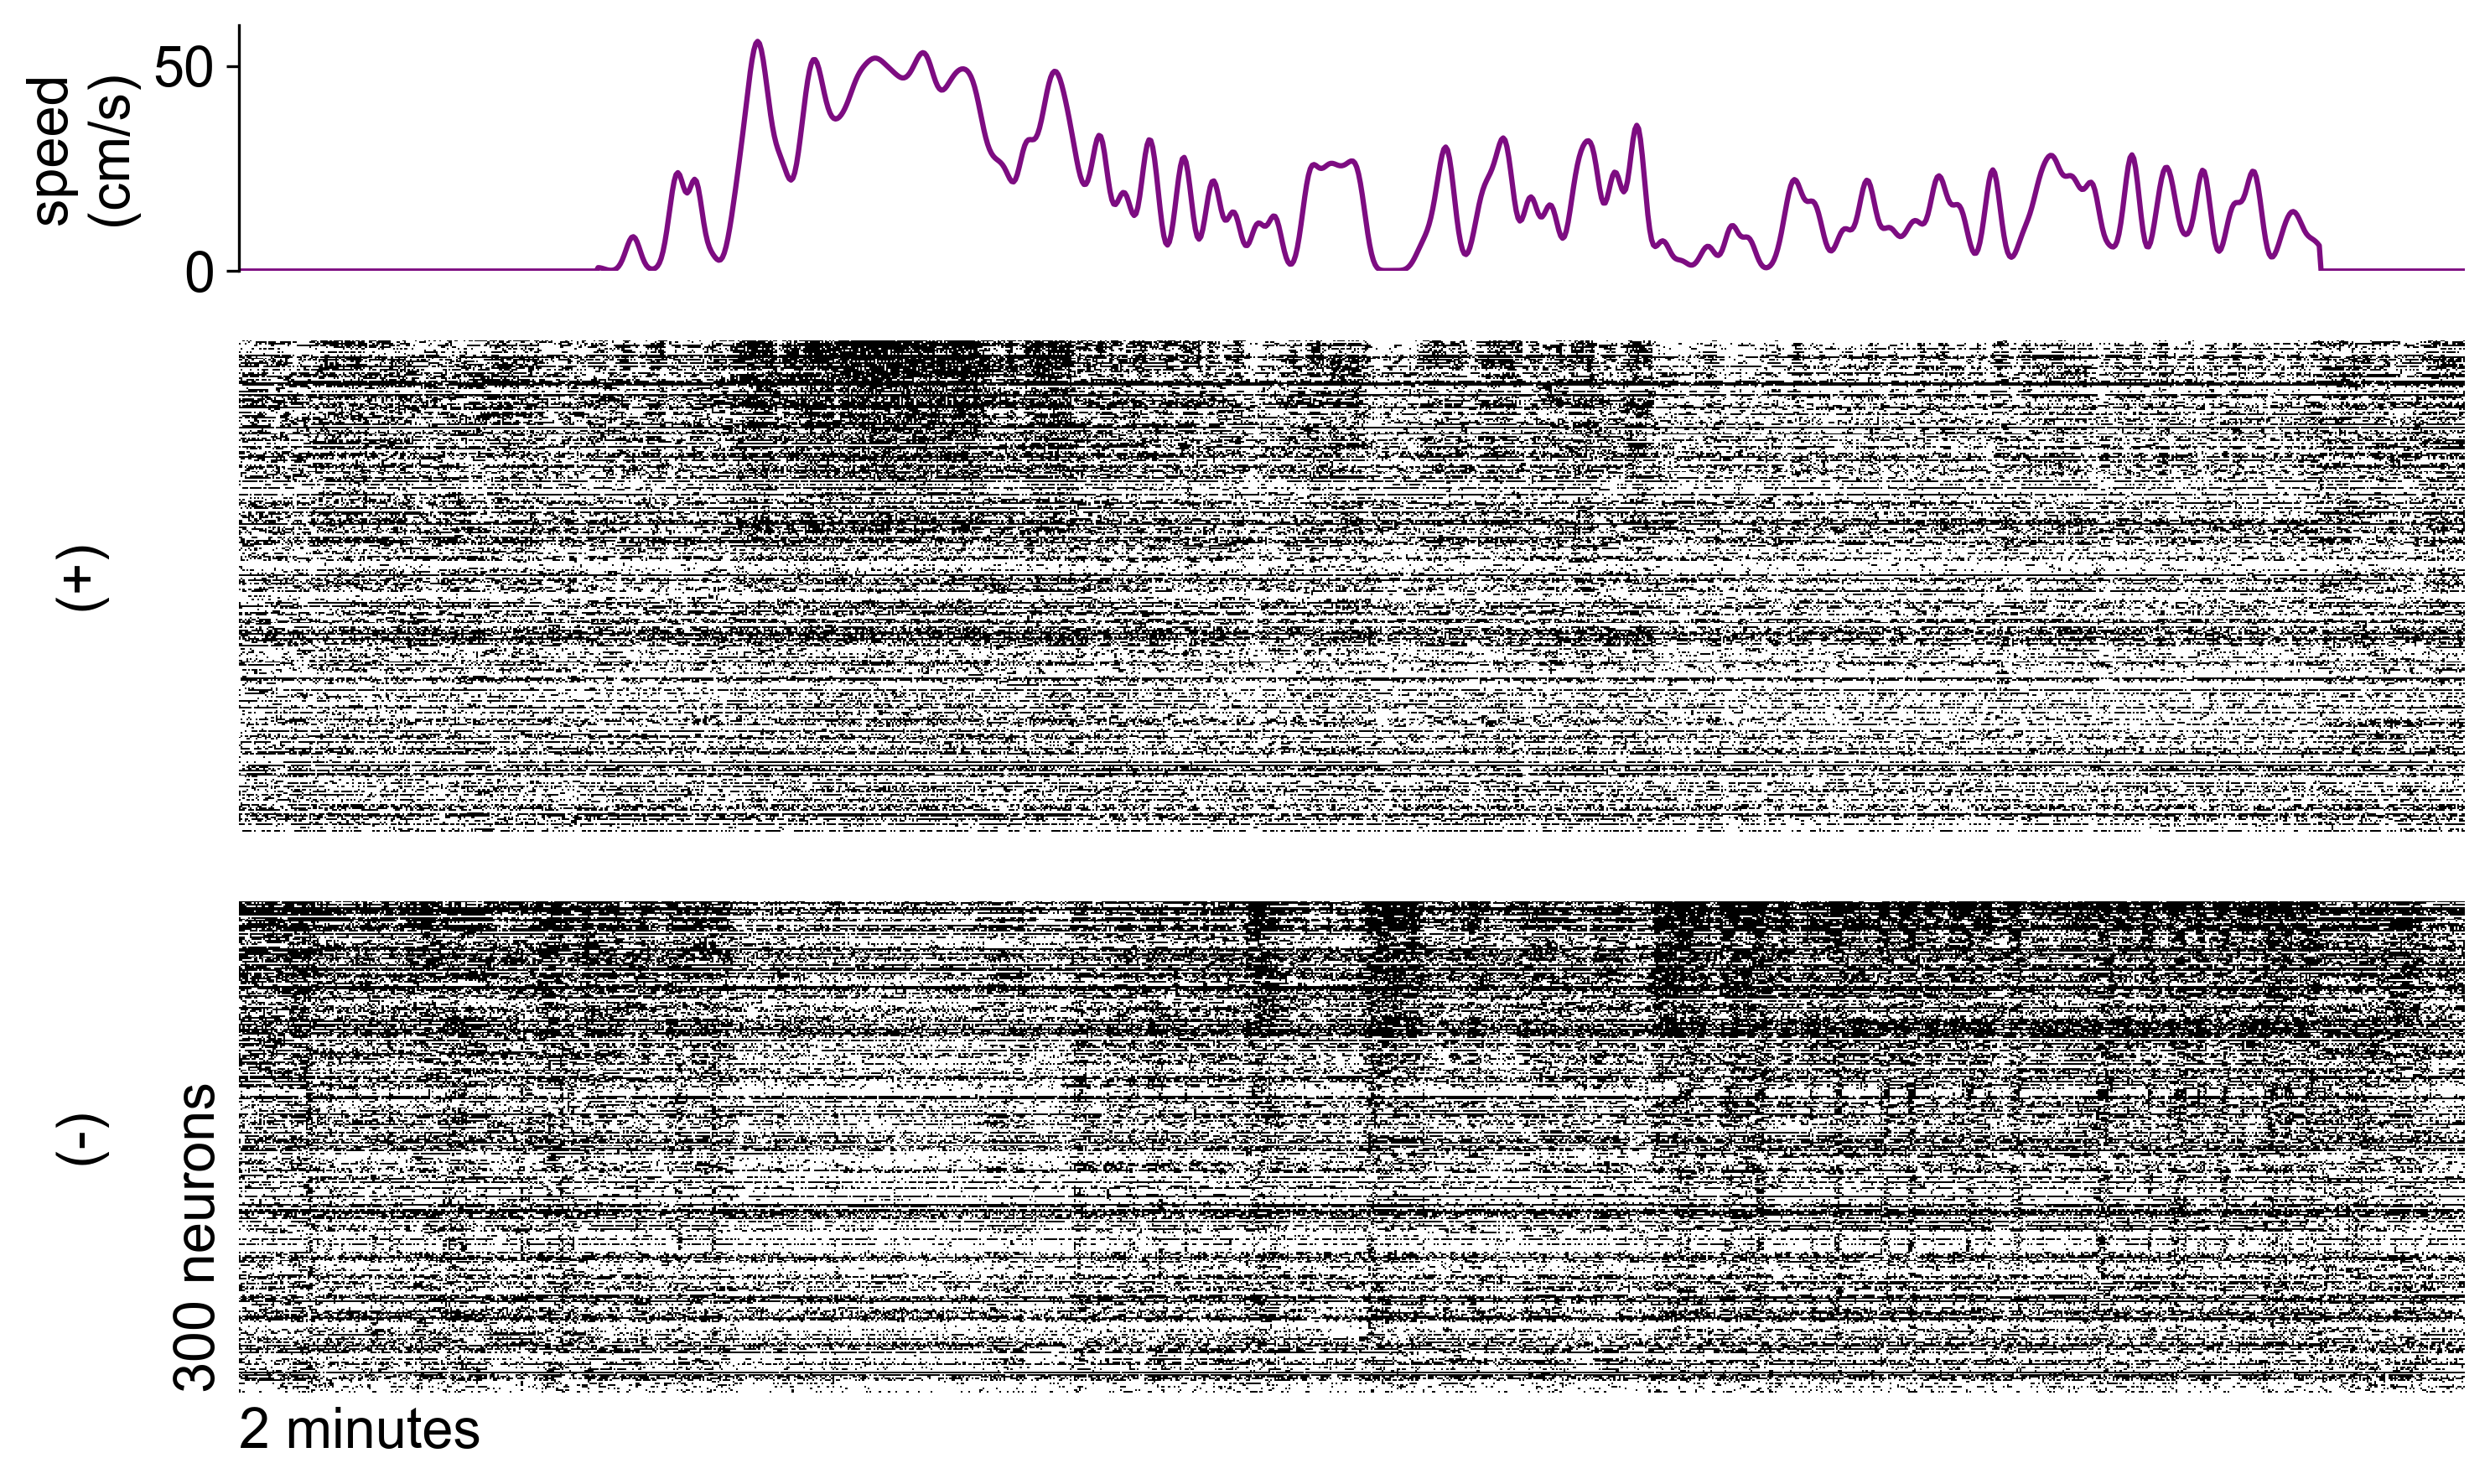

In [1190]:
plot_raster_pos_neg(spike_counts, speed_wheel, mask_wheel, corr_wheel, color="#7D0C81", n_neurons=300, w_start=4500, w_end=5700, save_path='wheel_raster_300_neurons', save=True)


In [405]:
from scipy import stats

In [207]:
r = 17
speed_arena = results[r].behavior.speed_arena
speed_wheel = results[r].behavior.speed_wheel
mask_arena = results[r].behavior.mask_arena
mask_wheel = results[r].behavior.mask_wheel
spike_counts = results[r].spike_counts

In [1164]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_multi_session_histograms(all_session_results, context='wheel', 
                                  figsize=(10, 6), save_path=None, save=False):
    """
    Plot correlation histograms for all sessions overlaid, separated by brain region.
    
    Parameters:
    -----------
    all_session_results : list
        List of session results from analyze_all_sessions
    context : str
        'arena' or 'wheel' - which correlations to plot
    """
    
    # Separate sessions by brain region
    hc_sessions = []
    mos_sessions = []
    
    for result in all_session_results:
        if result.spike_counts is None:
            continue
            
        if result.metadata.subject_id[:2] == 'EB':
            hc_sessions.append(result)
        else:
            mos_sessions.append(result)

    if len(hc_sessions) > 5:
        hc_sessions = random.sample(hc_sessions, 5)
    if len(mos_sessions) > 5:
        mos_sessions = random.sample(mos_sessions, 5)
    
    # Create figure with 2 subplots side by side
    fig, ( ax_mos, ax_hc) = plt.subplots(1, 2, figsize=figsize, sharey=True,dpi =300)
    
    # Plot all HC sessions overlaid
    for i, session in enumerate(hc_sessions):
        correlations = getattr(session.correlations, context)
        ax_hc.hist(correlations, bins=100, orientation='horizontal', 
               color='#195A2C', alpha=0.7, edgecolor='none',
               bottom=i*170) 
    
    # Plot all MOs sessions overlaid
    for i,session in enumerate(mos_sessions):
        correlations = getattr(session.correlations, context)
        ax_mos.hist(correlations, bins=100, orientation='horizontal', 
                    color='#195A2C',alpha=0.7,edgecolor='none',
               bottom=i*200)
    
    # Formatting for both axes
    for ax, label in zip([ax_hc, ax_mos], ['Hippocampus', 'Motor Cortex']):
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticklabels(np.arange(-0.5, 0.51, 0.5), fontsize=12)
        ax.set_yticks(np.arange(-0.5, 0.51, 0.5))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        


        ax.axhline(0.0, color="#1F1F1F", linestyle='--', linewidth=1.5, alpha=0.5)
    
    # Only label y-axis on the left subplot
    ax_mos.set_ylabel('Pearson correlation', fontsize=14)
    ax_mos.spines
    # For HC subplot
    ax_hc.set_xticks([i*170  for i in range(len(hc_sessions))])
    ax_hc.set_xticklabels([f'HC{i+1}' for i in range(len(hc_sessions))], fontsize=12)
   

    # For MOs subplot  
    ax_mos.set_xticks([i*200 for i in range(len(mos_sessions))])
    ax_mos.set_xticklabels([f'MOs{i+1}' for i in range(len(mos_sessions))], fontsize=12)
    
    plt.tight_layout()
    
    if save and save_path:
        plt.savefig(fr'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\{save_path}.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return fig




In [44]:
# Usage:
fig = plot_multi_session_histograms(results, context='arena', save_path='dist_random_5_arena', save=True)



NameError: name 'plot_multi_session_histograms' is not defined

In [223]:
def plot_reliability_stability(all_session_results):
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)

    reliability_values = []
    stability_values = []
    brain_regions = []
    subject_ids = []

    for result in all_session_results:
        if result.spike_counts is None:
            continue
        
        reliability_values.append(result.correlations.reliability)
        stability_values.append(result.correlations.stability)
        subject_ids.append(result.metadata.subject_id)
        
        if result.metadata.subject_id == 'EB036':
            brain_regions.append('hippocampus')
        elif result.metadata.subject_id == 'EB037':
            brain_regions.append('striatum')
        else:
            brain_regions.append('secondary motor cortex')

    reliability_values = np.array(reliability_values)
    stability_values = np.array(stability_values)
    brain_regions = np.array(brain_regions)
    subject_ids = np.array(subject_ids)

    # Define colors for each region/mouse
    colors = {
        'hippocampus': "#A5CB5D",  
        'striatum': "#E37A2A",
        'MOs(1)': "#660D0D",  # AV043 - darkest brown
        'MOs(2)': "#9F3A3A",  # GB011 - medium brown  
        'MOs(3)': "#D26E6E"   # GB012 - lighter brown
    }
    
    # Map MOs subject IDs to labels
    mos_mapping = {
        'AV043': 'MOs(1)',
        'GB011': 'MOs(2)', 
        'GB012': 'MOs(3)'
    }
    
    # Plot hippocampus
    mask = brain_regions == 'hippocampus'
    if np.any(mask):
        ax.scatter(reliability_values[mask], 
                stability_values[mask], 
                c=colors['hippocampus'],
                s=150,  
                alpha=0.7,  
                edgecolors='none',  
                linewidth=0.5,
                label='hippocampus',
                zorder=3)
    
    # Plot striatum
    mask = brain_regions == 'striatum'
    if np.any(mask):
        ax.scatter(reliability_values[mask], 
                stability_values[mask], 
                c=colors['striatum'],
                s=150,  
                alpha=0.7,  
                edgecolors='none',  
                linewidth=0.5,
                label='striatum',
                zorder=3)
    
    # Plot each MOs mouse separately (in order so they appear together in legend)
    for subject_id, mos_label in mos_mapping.items():
        mask = (brain_regions == 'secondary motor cortex') & (subject_ids == subject_id)
        if np.any(mask):
            ax.scatter(reliability_values[mask], 
                    stability_values[mask], 
                    c=colors[mos_label],
                    s=150,  
                    alpha=0.7,  
                    edgecolors='none',  
                    linewidth=0.5,
                    label=mos_label,
                    zorder=3)

    ax.plot([0, 1], [0, 1], 'k-', linewidth=1, alpha=0.5, zorder=1, ls='--')

    ax.set_xlim(-0.10, 1.05)
    ax.set_ylim(-0.10, 1.05)

    ax.set_xlabel('reliability', fontsize=20)
    ax.set_ylabel('stability', fontsize=20)

    # Add legend
    legend = ax.legend(loc='upper left', 
                    frameon=False, 
                    fancybox=False,
                    edgecolor='black',
                    fontsize=18)
    legend.get_frame().set_linewidth(0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5, length=6)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(np.arange(0, 1.1, 0.5))
    ax.set_yticks(np.arange(0, 1.1, 0.5))
    plt.rcParams['font.sans-serif'] = ['Arial']

    plt.tight_layout()

In [141]:
subject_id= 'AV043'
date= '2024-03-13'

In [145]:
video_path = fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}.mp4'

frame_idx= 1365
    

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()
cap.release()

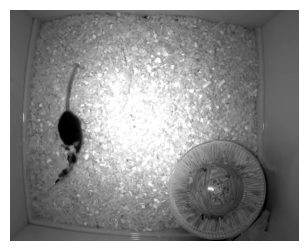

In [185]:
frame_idx = 1365
clean_frame= plt.subplots(figsize=(4, 3))
plt.imshow(frame)
plt.axis('off')
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\bland_frame.png', bbox_inches ='tight', dpi=300)


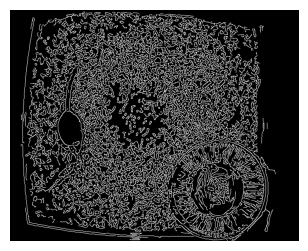

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 25, 50)

plt.figure(figsize=(4, 3))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\canny_frame.png', 
            bbox_inches='tight', dpi=300)



In [ ]:
import numpy as np

sessions_with_spikes = [s for s in sessions if s.spike_counts is not None]
print(f"Sessions with spike data: {len(sessions_with_spikes)}/{len(sessions)}")

error = []

for session in sessions_with_spikes:

    mask_wheel= session.behavior.mask_wheel
    mask_arena= session.behavior.mask_arena
    corner= session.behavior.corner
    displacement = np.diff(session.behavior.rotary_position)
    displacement= np.insert(displacement, 0, 0)


    wheel_moving = np.abs(displacement) > 0




    valid_data_mask = ~corner

    mask_wheel = mask_wheel[valid_data_mask]
    wheel_moving = wheel_moving[valid_data_mask]
    tp = np.sum(mask_wheel & wheel_moving)
    fn = np.sum(~mask_wheel & wheel_moving)
    bp = np.sum(mask_wheel & ~wheel_moving)
    tn = np.sum(~mask_wheel & ~wheel_moving)

    total_moving_time = tp + fn
    if total_moving_time > 0:
        critical_error_rate = fn / total_moving_time
        error.append(critical_error_rate)
        
    else:
        print("1. Critical Error Rate: N/A (No wheel movement was detected in the valid data.)\n")


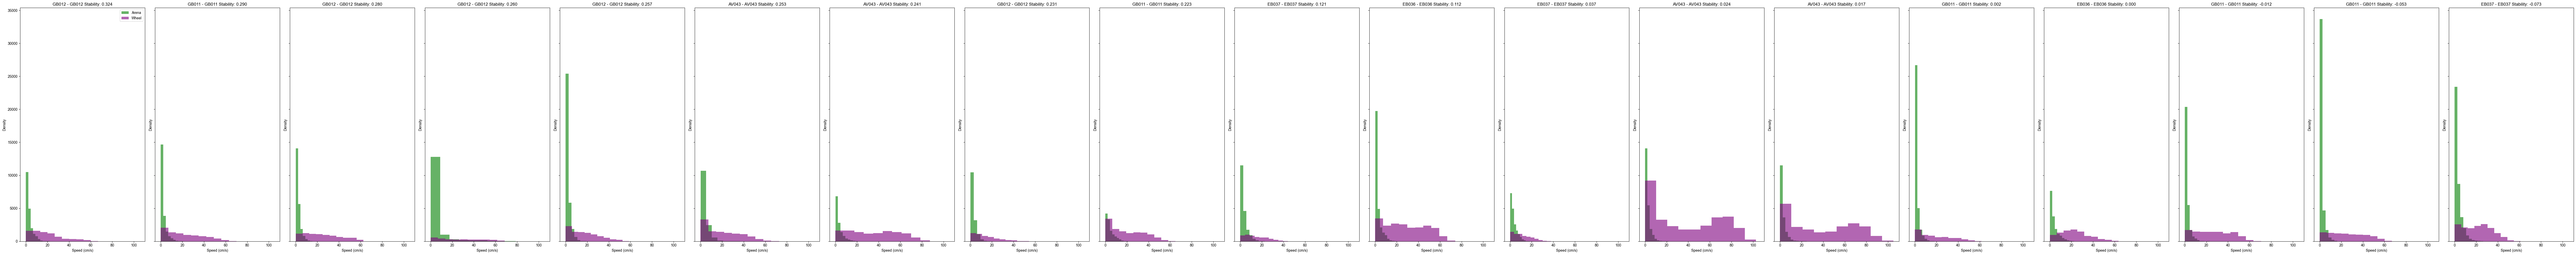

In [795]:
# Get stability scores as a list
stability_scores = [r.correlations.stability for r in results 
                   if hasattr(r.correlations, 'stability')]
subject_ids = [r.metadata.subject_id for r in results 
                   if hasattr(r.correlations, 'stability')]
dates = [r.metadata.subject_id for r in results 
                   if hasattr(r.correlations, 'stability')]
speed_arena= [r.behavior.speed_arena for r in results 
                   if hasattr(r.correlations, 'stability')]

speed_wheel= [r.behavior.speed_wheel for r in results 
                   if hasattr(r.correlations, 'stability')]

mask_arena= [r.behavior.mask_arena for r in results 
                   if hasattr(r.correlations, 'stability')]

mask_wheel= [r.behavior.mask_wheel for r in results 
                   if hasattr(r.correlations, 'stability')]


# Get masks for filtering speeds
mask_arena = [r.behavior.mask_arena for r in results 
              if hasattr(r.correlations, 'stability')]

mask_wheel = [r.behavior.mask_wheel for r in results 
              if hasattr(r.correlations, 'stability')]

# Sort everything by stability scores (highest to lowest)
sorted_indices = np.argsort(stability_scores)[::-1]

# Apply sorting to all lists
stability_scores = [stability_scores[i] for i in sorted_indices]
subject_ids = [subject_ids[i] for i in sorted_indices]
dates = [dates[i] for i in sorted_indices]
speed_arena = [speed_arena[i] for i in sorted_indices]
speed_wheel = [speed_wheel[i] for i in sorted_indices]
mask_arena = [mask_arena[i] for i in sorted_indices]
mask_wheel = [mask_wheel[i] for i in sorted_indices]





for idx in range(len(stability_scores)):

    arena_speed = speed_arena[idx][mask_arena[idx]]
    wheel_speed = speed_wheel[idx][mask_wheel[idx]]
    arena_counts, _ = np.histogram(arena_speed)
    wheel_counts, _ = np.histogram(wheel_speed)
    max_count = max(max_count, arena_counts.max(), wheel_counts.max())

# Setup plot
n = len(stability_scores)
n_cols = 19
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(100, 10), 
                         sharey=True, sharex=True)  # Share both axes
axes = axes.flatten() if n > 1 else [axes]

# Plot each session
for idx in range(n):
    ax = axes[idx]
    
    # Get speeds for each context using masks
    arena_speed = speed_arena[idx][mask_arena[idx]]
    wheel_speed = speed_wheel[idx][mask_wheel[idx]]
    
    # Plot distributions
    ax.hist(arena_speed, alpha=0.6, color='green', label='Arena')
    ax.hist(wheel_speed, alpha=0.6, color='purple', label='Wheel')

    
    
    ax.set_title(f'{subject_ids[idx]} - {dates[idx]} Stability: {stability_scores[idx]:.3f}')
    ax.set_xlabel('Speed (cm/s)')
    ax.set_ylabel('Density')
    if idx == 0:
        ax.legend()

# Hide unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()